## Project Title
**Data-Driven Real Estate Valuation: Crime, Amenities & Location**

## Team Members
1. Vishveshwara Guthal (guthal)
2. Ariscia Mendes (amende17)
3. Swetha Narasimhan (Swetha1999)(POC)
4. Amaan Ali Khan (ak0477)

## Overview
**Objective**

We are developing a machine learning model to predict real estate prices more accurately by analyzing four critical factors:
1. Location
2. Property characteristics
3. Accessibility to amenities
4. Economic & crime data

**Impact & Stakeholders**

1. Real Estate Agents: Make informed pricing recommendations using AI-driven analytics.
2. Homebuyers & Investors: Get transparent, data-backed pricing insights, especially in high/low-crime areas.
3. Urban Planners & Local Authorities: Understand how crime and amenities shape housing demand for better policy decisions.

## DataSet 
https://data.cityofnewyork.us/Public-Safety/lat-and-long-google-maps/rjv2-9zvt/about_data


## Preprocessing

In [133]:
import warnings
warnings.filterwarnings('ignore')


## Importing Data
**Import the unclean, raw, scraped data from Realtor.com**

In [134]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("unclean.csv" )

In [135]:
df["Property Value"].min()

'$1'

In [136]:
df['Zip Code'] = df['Address line 2'].str.extract(r'(\d{5})')

**Display Dataset using head function**

In [137]:
df = df.dropna(subset=['Zip Code']).copy()
df.shape

(16610, 46)

**Dropping rows with missing target variable**

In [138]:
df.drop_duplicates(keep="first", inplace=True)
print("Duplicates removed. New shape:", df.shape)

Duplicates removed. New shape: (10469, 46)


**Dropping rows with missing target variable**

In [139]:
df = df.dropna(subset=['Property Value']).copy()

## Removing unwanted columns
**Removing irrelevant columns to our model such as the property URL, Address data, etc.**

In [140]:
columns_to_drop = [
    "Property Link",
    "Address line 1",
    "Address line 2",
    "Full Address_x",
    "Full Address_y",
    "\r\nbed",
    "appreciate/depreciate",
    
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [141]:
df.columns

Index(['Type of House', 'Property Value', 'bed', 'bath', 'Area (Sqft)',
       'PropertyLotSizeMetastyles__StyledPropertyLotSizeMeta-rui__sc-1cz4zco-0',
       'lot size', 'Latitude', 'Longitude', 'Number_of_Parks_Nearby',
       'Distance_to_Nearest_Parks_miles', 'Number_of_Malls_Nearby',
       'Distance_to_Nearest_Malls_miles', 'Number_of_Metros_Nearby',
       'Distance_to_Nearest_Metros_miles', 'Number_of_Clubs_Nearby',
       'Distance_to_Nearest_Clubs_miles', 'Number_of_Restaurants_Nearby',
       'Distance_to_Nearest_Restaurants_miles', 'Number_of_Schools_Nearby',
       'Distance_to_Nearest_Schools_miles', 'Number_of_Colleges_Nearby',
       'Distance_to_Nearest_Colleges_miles', 'Number_of_Universities_Nearby',
       'Distance_to_Nearest_Universities_miles', 'Number_of_Buses_Nearby',
       'Distance_to_Nearest_Buses_miles', 'Number_of_Trains_Nearby',
       'Distance_to_Nearest_Trains_miles', 'Number_of_Airports_Nearby',
       'Distance_to_Nearest_Airports_miles', 'Number_o

## Converting datatypes
**Remove "$" from target and convert to numerical.**

In [142]:
df["Property Value"] = (
    df["Property Value"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df = df[df["Property Value"].str.replace(".", "", regex=False).str.isnumeric()]

df["Property Value"] = df["Property Value"].astype(float)

print(df["Property Value"].head())


0    150000000.0
1       649000.0
2      6999999.0
3     18000000.0
4       274000.0
Name: Property Value, dtype: float64


In [143]:
df.columns

Index(['Type of House', 'Property Value', 'bed', 'bath', 'Area (Sqft)',
       'PropertyLotSizeMetastyles__StyledPropertyLotSizeMeta-rui__sc-1cz4zco-0',
       'lot size', 'Latitude', 'Longitude', 'Number_of_Parks_Nearby',
       'Distance_to_Nearest_Parks_miles', 'Number_of_Malls_Nearby',
       'Distance_to_Nearest_Malls_miles', 'Number_of_Metros_Nearby',
       'Distance_to_Nearest_Metros_miles', 'Number_of_Clubs_Nearby',
       'Distance_to_Nearest_Clubs_miles', 'Number_of_Restaurants_Nearby',
       'Distance_to_Nearest_Restaurants_miles', 'Number_of_Schools_Nearby',
       'Distance_to_Nearest_Schools_miles', 'Number_of_Colleges_Nearby',
       'Distance_to_Nearest_Colleges_miles', 'Number_of_Universities_Nearby',
       'Distance_to_Nearest_Universities_miles', 'Number_of_Buses_Nearby',
       'Distance_to_Nearest_Buses_miles', 'Number_of_Trains_Nearby',
       'Distance_to_Nearest_Trains_miles', 'Number_of_Airports_Nearby',
       'Distance_to_Nearest_Airports_miles', 'Number_o

## Normalize units (lot size)
**Creating a derived variable called "Total lot size" from "lot type" and "lot size"**

In [144]:
df.rename(
    columns={"PropertyLotSizeMetastyles__StyledPropertyLotSizeMeta-rui__sc-1cz4zco-0": "lot type"},
    inplace=True
)

df["lot size"] = pd.to_numeric(df["lot size"].astype(str).str.replace(",", ""), errors="coerce")
df["Area (Sqft)"] = pd.to_numeric(df["Area (Sqft)"].astype(str).str.replace(",", ""), errors="coerce")

# 3. Compute total lot size based on logic
def compute_total_lot_size(row):
    lot_type = str(row["lot type"]).lower() if pd.notna(row["lot type"]) else ""
    lot_size = row["lot size"]
    area_sqft = row["Area (Sqft)"]

    if "acre lot" in lot_type and pd.notna(lot_size):
        return lot_size * 43560
    elif "sqft lot" in lot_type and pd.notna(lot_size):
        return lot_size
    else:
        return area_sqft  

df["total lot size(sqft)"] = df.apply(compute_total_lot_size, axis=1)

df["total lot size(sqft)"] = pd.to_numeric(df["total lot size(sqft)"], errors="coerce")

In [145]:
df.drop(columns=["lot size", "lot type"], inplace=True)

In [146]:
df.head()

Type of House  Property Value bed  bath  Area (Sqft)   Latitude  \
0      Condo for sale     150000000.0   8    10      11535.0  40.766474   
1      Condo for sale        649000.0   3   2.5       2431.0  40.826130   
2  Townhouse for sale       6999999.0   6  6.5+       7200.0  40.787587   
3      House for sale      18000000.0   8  16.5      33000.0  40.595008   
4      House for sale        274000.0   3     1       1556.0  40.675746   

   Longitude  Number_of_Parks_Nearby  Distance_to_Nearest_Parks_miles  \
0 -73.981266                      16                         0.516540   
1 -73.943006                      37                         0.057431   
2 -73.969240                      19                         0.148955   
3 -74.106434                       1                         1.515412   
4 -73.822413                      14                         0.953825   

   Number_of_Malls_Nearby  ...  Distance_to_Nearest_Airports_miles  \
0                       3  ...                            2.205337   
1                       0  ...                                 inf   
2                       2  ...                                 inf   
3                       0  ...                                 inf   
4                       1  ...                                 inf   

   Number_of_Museums_Nearby  Distance_to_Nearest_Museums_miles  \
0                        34                           0.466477   
1                        14                           0.313484   
2                        17                           0.458300   
3                         4                           2.116247   
4                         0                                inf   

   Number_of_Libraries_Nearby  Distance_to_Nearest_Libraries_miles  \
0                          26                             0.228443   
1                           9                             0.372547   
2                          22                             0.580740   
3                           1                             1.616244   
4                           1                             1.638993   

   Number_of_Grocery_stores_Nearby  Distance_to_Nearest_Grocery_stores_miles  \
0                              194                                  0.151832   
1                              101                                  0.235285   
2                              154                                  0.129664   
3                               22                                  1.005562   
4                               52                                  0.216965   

         borough  Zip Code  total lot size(sqft)  
0      Manhattan     10019               11535.0  
1      Manhattan     10031                2431.0  
2      Manhattan     10024                7200.0  
3  Staten Island     10304               68824.8  
4         Queens     11420                2400.0  

[5 rows x 38 columns]

## Handling missing values through imputation

**Displaying missing values**

In [147]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())

print("\n--- Numeric Summary ---")
print(df.describe(include='number'))



--- Missing Values per Column ---
Type of House                                  0
Property Value                                 0
bed                                          206
bath                                         315
Area (Sqft)                                 2799
Latitude                                       0
Longitude                                      0
Number_of_Parks_Nearby                         0
Distance_to_Nearest_Parks_miles                0
Number_of_Malls_Nearby                         0
Distance_to_Nearest_Malls_miles                0
Number_of_Metros_Nearby                        0
Distance_to_Nearest_Metros_miles               0
Number_of_Clubs_Nearby                         0
Distance_to_Nearest_Clubs_miles                0
Number_of_Restaurants_Nearby                   0
Distance_to_Nearest_Restaurants_miles          0
Number_of_Schools_Nearby                       0
Distance_to_Nearest_Schools_miles              0
Number_of_Colleges_Nearby         

**For "Bed" and "Bath" we impute using mode**

In [148]:
most_common_bed = df["bed"].mode()[0]
df["bed"].fillna(most_common_bed, inplace=True)

median_bath = df["bath"].mode()[0]
df["bath"].fillna(median_bath, inplace=True)

**For Area sq.ft we fill missing Area using group-wise median**

In [149]:
df["Area (Sqft)"] = (
    df["Area (Sqft)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace("nan", np.nan) 
    .astype(float)
)

In [150]:
df["Area (Sqft)_original"] = df["Area (Sqft)"]

df["bed"] = df["bed"].fillna(df["bed"].mode()[0])
df["bed"] = df["bed"].astype(str) 

def impute_area(row):
    if pd.isna(row["Area (Sqft)"]):        
        group_median = grouped_medians.get((row["bed"], row["Type of House"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        
        group_median = fallback_medians.get((row["bed"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        
        group_median = bed_medians.get(row["bed"])
        if pd.notna(group_median):
            return group_median
        
        return df["Area (Sqft)"].median()
    return row["Area (Sqft)"]


grouped_medians = df.groupby(["bed", "Type of House", "borough"])["Area (Sqft)"].median().to_dict()
fallback_medians = df.groupby(["bed", "borough"])["Area (Sqft)"].median().to_dict()
bed_medians = df.groupby("bed")["Area (Sqft)"].median().to_dict()

df["Area (Sqft)"] = df.apply(impute_area, axis=1)


**We Impute in same way for Total Lot size(sqft)**

In [151]:
df["total lot size(sqft)_original"] = df["total lot size(sqft)"]

df["bed"] = df["bed"].fillna(df["bed"].mode()[0])
df["bed"] = df["bed"].astype(str)

df["bath"] = df["bath"].fillna(df["bath"].mode()[0])
df["bath"] = df["bath"].astype(str)

# Define imputation function
def impute_total_lot_size(row):
    if pd.isna(row["total lot size(sqft)"]):
        
        group_median = grouped_medians.get((row["bed"], row["Type of House"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        
        group_median = fallback_medians.get((row["bed"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        
        group_median = bed_medians.get(row["bed"])
        if pd.notna(group_median):
            return group_median
        
        return df["total lot size(sqft)"].median()
    return row["total lot size(sqft)"]

grouped_medians = df.groupby(["bed", "Type of House", "borough"])["total lot size(sqft)"].median().to_dict()
fallback_medians = df.groupby(["bed", "borough"])["total lot size(sqft)"].median().to_dict()
bed_medians = df.groupby("bed")["total lot size(sqft)"].median().to_dict()

df["total lot size(sqft)"] = df.apply(impute_total_lot_size, axis=1)


In [152]:
df.drop(columns=["Area (Sqft)_original", "total lot size(sqft)_original"], inplace=True)

**checking missing values once again after imputation**

In [153]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())


--- Missing Values per Column ---
Type of House                               0
Property Value                              0
bed                                         0
bath                                        0
Area (Sqft)                                 0
Latitude                                    0
Longitude                                   0
Number_of_Parks_Nearby                      0
Distance_to_Nearest_Parks_miles             0
Number_of_Malls_Nearby                      0
Distance_to_Nearest_Malls_miles             0
Number_of_Metros_Nearby                     0
Distance_to_Nearest_Metros_miles            0
Number_of_Clubs_Nearby                      0
Distance_to_Nearest_Clubs_miles             0
Number_of_Restaurants_Nearby                0
Distance_to_Nearest_Restaurants_miles       0
Number_of_Schools_Nearby                    0
Distance_to_Nearest_Schools_miles           0
Number_of_Colleges_Nearby                   0
Distance_to_Nearest_Colleges_miles          0

In [154]:
df.shape

(10468, 38)

## Handling Outliers

In [155]:
numeric_cols = [
    "Property Value",
    "Area (Sqft)",
    "total lot size(sqft)",
    "Number_of_Parks_Nearby",
    "Number_of_Malls_Nearby",
    "Number_of_Metros_Nearby",
    "Number_of_Clubs_Nearby",
    "Number_of_Restaurants_Nearby",
    "Number_of_Schools_Nearby",
    "Number_of_Colleges_Nearby",
    "Number_of_Universities_Nearby",
    "Number_of_Buses_Nearby",
    "Number_of_Trains_Nearby",
    "Number_of_Airports_Nearby",
    "Number_of_Museums_Nearby",
    "Number_of_Libraries_Nearby",
    "Number_of_Grocery_stores_Nearby"
]

In [156]:
min_caps = {
    "Property Value": 50000,
    "Area (Sqft)": 200,
    "total lot size(sqft)": 200,
    "Number_of_Parks_Nearby": 0,
    "Number_of_Malls_Nearby": 0,
    "Number_of_Metros_Nearby": 0,
    "Number_of_Clubs_Nearby": 0,
    "Number_of_Restaurants_Nearby": 0,
    "Number_of_Schools_Nearby": 0,
    "Number_of_Colleges_Nearby": 0,
    "Number_of_Universities_Nearby": 0,
    "Number_of_Buses_Nearby": 0,
    "Number_of_Trains_Nearby": 0,
    "Number_of_Airports_Nearby": 0,
    "Number_of_Museums_Nearby": 0,
    "Number_of_Libraries_Nearby": 0,
    "Number_of_Grocery_stores_Nearby": 0
}

In [157]:
def clip_outliers_iqr(df, columns, iqr_factor=1.5, min_caps=None):
    df_clipped = df.copy()
    for col in columns:
        if col in df_clipped.columns:
            Q1 = df_clipped[col].quantile(0.25)
            Q3 = df_clipped[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - iqr_factor * IQR
            upper = Q3 + iqr_factor * IQR

            if min_caps and col in min_caps:
                lower = max(lower, min_caps[col])

            before_min = df_clipped[col].min()
            before_max = df_clipped[col].max()

            df_clipped[col] = df_clipped[col].clip(lower=lower, upper=upper)

            print(f"{col}: clipped to [{lower:,.0f}, {upper:,.0f}] | Before: ({before_min:,.0f}, {before_max:,.0f}) → After: ({df_clipped[col].min():,.0f}, {df_clipped[col].max():,.0f})")
    return df_clipped

In [158]:
df = clip_outliers_iqr(df, numeric_cols, iqr_factor=1.5, min_caps=min_caps)
df.shape

Property Value: clipped to [50,000, 3,557,950] | Before: (1, 150,000,000) → After: (50,000, 3,557,950)
Area (Sqft): clipped to [200, 4,522] | Before: (167, 212,250) → After: (200, 4,522)
total lot size(sqft): clipped to [200, 9,785] | Before: (167, 95,091,480) → After: (200, 9,785)
Number_of_Parks_Nearby: clipped to [0, 42] | Before: (0, 57) → After: (0, 42)
Number_of_Malls_Nearby: clipped to [0, 5] | Before: (0, 3) → After: (0, 3)
Number_of_Metros_Nearby: clipped to [0, 226] | Before: (0, 165) → After: (0, 165)
Number_of_Clubs_Nearby: clipped to [0, 66] | Before: (0, 57) → After: (0, 57)
Number_of_Restaurants_Nearby: clipped to [0, 5,564] | Before: (0, 3,475) → After: (0, 3,475)
Number_of_Schools_Nearby: clipped to [0, 386] | Before: (0, 233) → After: (0, 233)
Number_of_Colleges_Nearby: clipped to [0, 24] | Before: (0, 16) → After: (0, 16)
Number_of_Universities_Nearby: clipped to [0, 32] | Before: (0, 23) → After: (0, 23)
Number_of_Buses_Nearby: clipped to [0, 2,566] | Before: (0, 1,

(10468, 38)

In [159]:
df.head()

Type of House  Property Value bed  bath  Area (Sqft)   Latitude  \
0      Condo for sale       3557950.0   8    10     4522.375  40.766474   
1      Condo for sale        649000.0   3   2.5     2431.000  40.826130   
2  Townhouse for sale       3557950.0   6  6.5+     4522.375  40.787587   
3      House for sale       3557950.0   8  16.5     4522.375  40.595008   
4      House for sale        274000.0   3     1     1556.000  40.675746   

   Longitude  Number_of_Parks_Nearby  Distance_to_Nearest_Parks_miles  \
0 -73.981266                      16                         0.516540   
1 -73.943006                      37                         0.057431   
2 -73.969240                      19                         0.148955   
3 -74.106434                       1                         1.515412   
4 -73.822413                      14                         0.953825   

   Number_of_Malls_Nearby  ...  Distance_to_Nearest_Airports_miles  \
0                       3  ...                            2.205337   
1                       0  ...                                 inf   
2                       2  ...                                 inf   
3                       0  ...                                 inf   
4                       1  ...                                 inf   

   Number_of_Museums_Nearby  Distance_to_Nearest_Museums_miles  \
0                        34                           0.466477   
1                        14                           0.313484   
2                        17                           0.458300   
3                         4                           2.116247   
4                         0                                inf   

   Number_of_Libraries_Nearby  Distance_to_Nearest_Libraries_miles  \
0                          26                             0.228443   
1                           9                             0.372547   
2                          22                             0.580740   
3                           1                             1.616244   
4                           1                             1.638993   

   Number_of_Grocery_stores_Nearby  Distance_to_Nearest_Grocery_stores_miles  \
0                              194                                  0.151832   
1                              101                                  0.235285   
2                              154                                  0.129664   
3                               22                                  1.005562   
4                               52                                  0.216965   

         borough  Zip Code  total lot size(sqft)  
0      Manhattan     10019               9785.25  
1      Manhattan     10031               2431.00  
2      Manhattan     10024               7200.00  
3  Staten Island     10304               9785.25  
4         Queens     11420               2400.00  

[5 rows x 38 columns]

In [160]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())


--- Missing Values per Column ---
Type of House                               0
Property Value                              0
bed                                         0
bath                                        0
Area (Sqft)                                 0
Latitude                                    0
Longitude                                   0
Number_of_Parks_Nearby                      0
Distance_to_Nearest_Parks_miles             0
Number_of_Malls_Nearby                      0
Distance_to_Nearest_Malls_miles             0
Number_of_Metros_Nearby                     0
Distance_to_Nearest_Metros_miles            0
Number_of_Clubs_Nearby                      0
Distance_to_Nearest_Clubs_miles             0
Number_of_Restaurants_Nearby                0
Distance_to_Nearest_Restaurants_miles       0
Number_of_Schools_Nearby                    0
Distance_to_Nearest_Schools_miles           0
Number_of_Colleges_Nearby                   0
Distance_to_Nearest_Colleges_miles          0

#### Feature Engineering (Binning)

In [161]:
import numpy as np
import pandas as pd

distance_cols = [col for col in df.columns if "Distance_to" in col and "miles" in col]

bins = [0, 1, 2, 3, 4, np.inf]
labels = ["0–1 miles", "1–2 miles", "2–3 miles", "3–4 miles", "4+ miles"]

for col in distance_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    binned_col = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    binned_col = binned_col.fillna("4+ miles")
    new_col_name = f"{col}_binned"
    df[new_col_name] = binned_col

    df.drop(columns=[col], inplace=True)


In [162]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['Type of House', 'bed', 'bath', 'borough', 'Zip Code', 'Distance_to_Nearest_Parks_miles_binned', 'Distance_to_Nearest_Malls_miles_binned', 'Distance_to_Nearest_Metros_miles_binned', 'Distance_to_Nearest_Clubs_miles_binned', 'Distance_to_Nearest_Restaurants_miles_binned', 'Distance_to_Nearest_Schools_miles_binned', 'Distance_to_Nearest_Colleges_miles_binned', 'Distance_to_Nearest_Universities_miles_binned', 'Distance_to_Nearest_Buses_miles_binned', 'Distance_to_Nearest_Trains_miles_binned', 'Distance_to_Nearest_Airports_miles_binned', 'Distance_to_Nearest_Museums_miles_binned', 'Distance_to_Nearest_Libraries_miles_binned', 'Distance_to_Nearest_Grocery_stores_miles_binned']


## Encoding categorical values using One-Hot encoding

In [163]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [164]:
df_encoded = df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
df_encoded.head()

Property Value  Area (Sqft)   Latitude  Longitude  Number_of_Parks_Nearby  \
0       3557950.0     4522.375  40.766474 -73.981266                      16   
1        649000.0     2431.000  40.826130 -73.943006                      37   
2       3557950.0     4522.375  40.787587 -73.969240                      19   
3       3557950.0     4522.375  40.595008 -74.106434                       1   
4        274000.0     1556.000  40.675746 -73.822413                      14   

   Number_of_Malls_Nearby  Number_of_Metros_Nearby  Number_of_Clubs_Nearby  \
0                       3                      110                      30   
1                       0                       72                       5   
2                       2                       88                       7   
3                       0                        7                       1   
4                       1                       30                       7   

   Number_of_Restaurants_Nearby  Number_of_Schools_Nearby  ...  \
0                          2786                       165  ...   
1                           572                       220  ...   
2                          1933                       192  ...   
3                           173                        16  ...   
4                           252                        32  ...   

   Distance_to_Nearest_Museums_miles_binned_3–4 miles  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   Distance_to_Nearest_Museums_miles_binned_4+ miles  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  1   

   Distance_to_Nearest_Libraries_miles_binned_1–2 miles  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  1      
4                                                  1      

   Distance_to_Nearest_Libraries_miles_binned_2–3 miles  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   Distance_to_Nearest_Libraries_miles_binned_3–4 miles  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   Distance_to_Nearest_Libraries_miles_binned_4+ miles  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Distance_to_Nearest_Grocery_stores_miles_binned_1–2 miles  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  1           
4                                                  0           

   Distance_to_Nearest_Grocery_stores_miles_binned_2–3 miles  \
0                                                  0           
1                                                

## Visualization

## Analyzing Numeric Feature Distributions
Generated boxplots for all numeric columns to examine their distributions. These visualizations help us identify key characteristics like median values, data spread (IQR), and potential outliers.

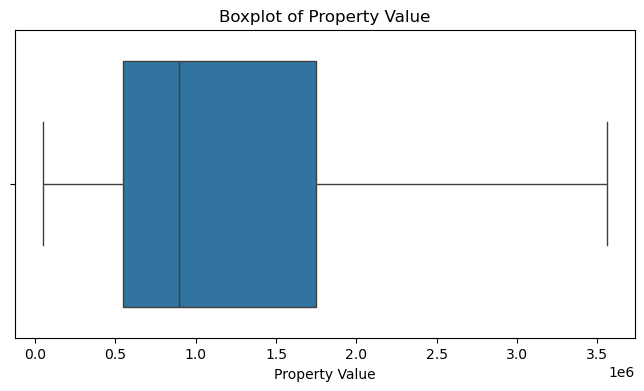

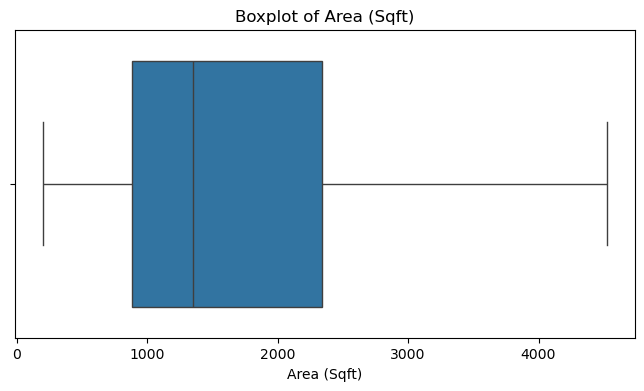

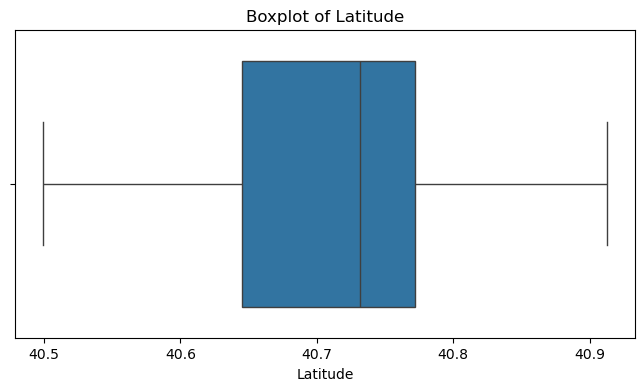

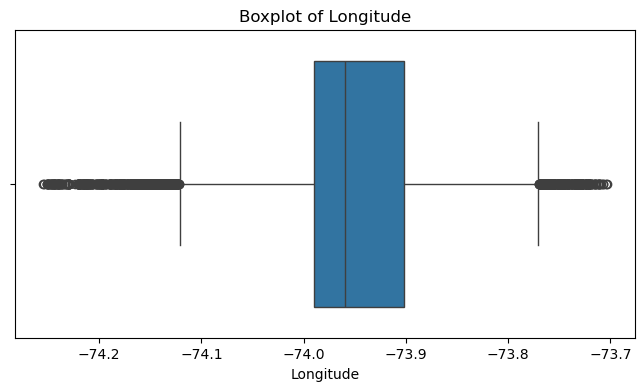

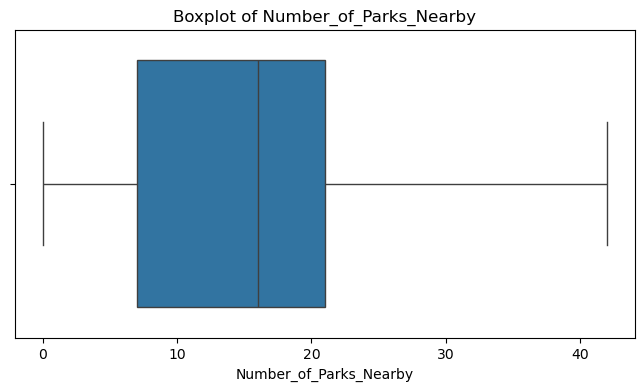

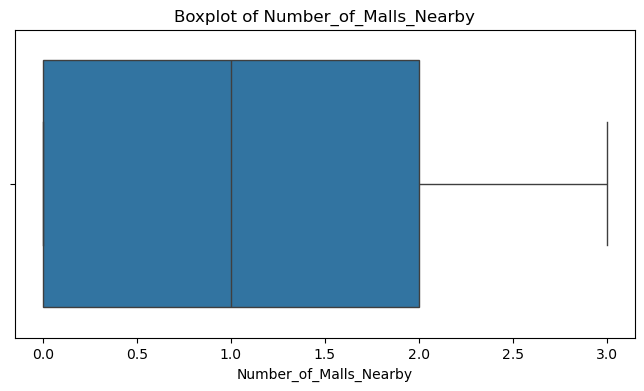

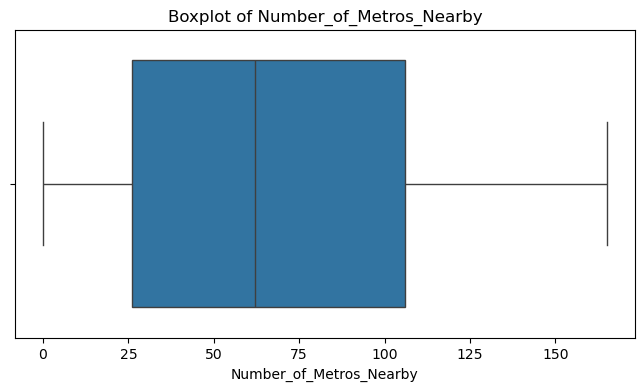

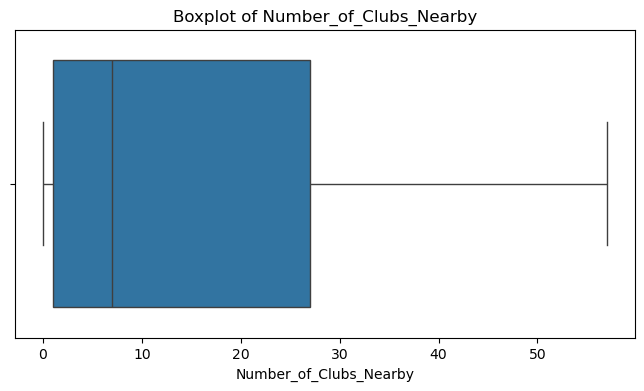

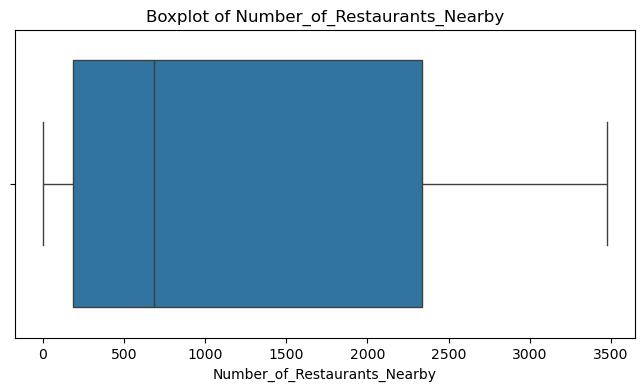

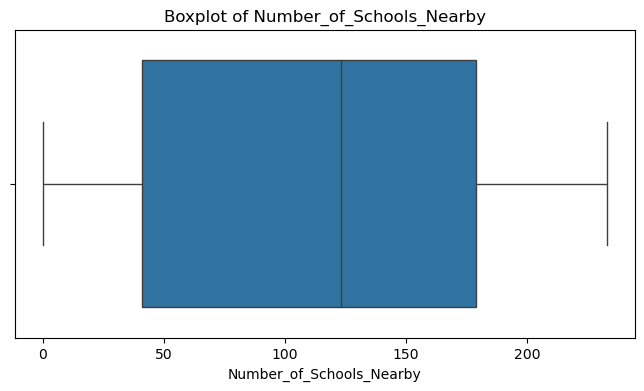

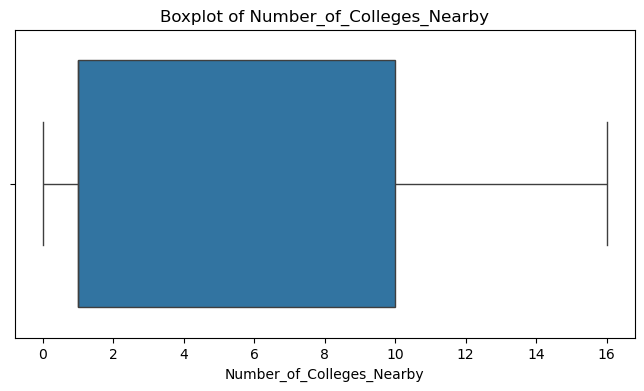

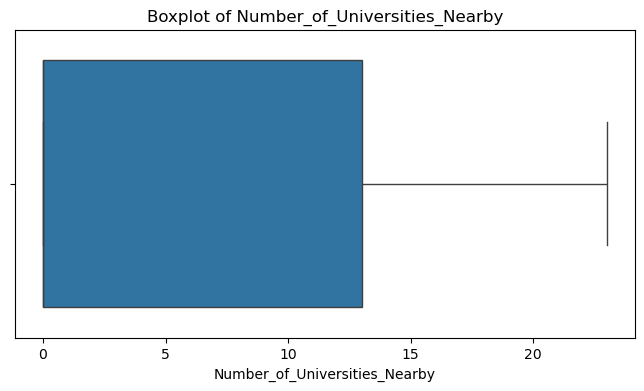

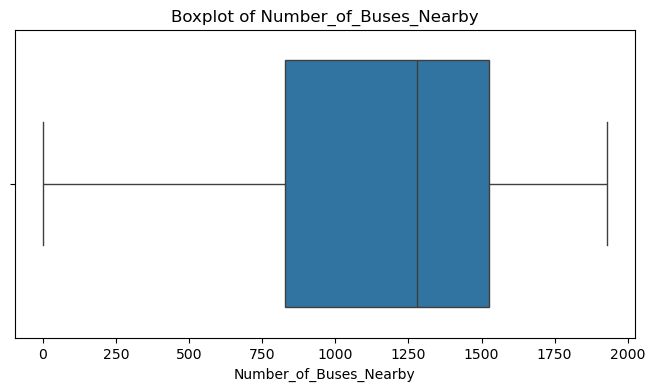

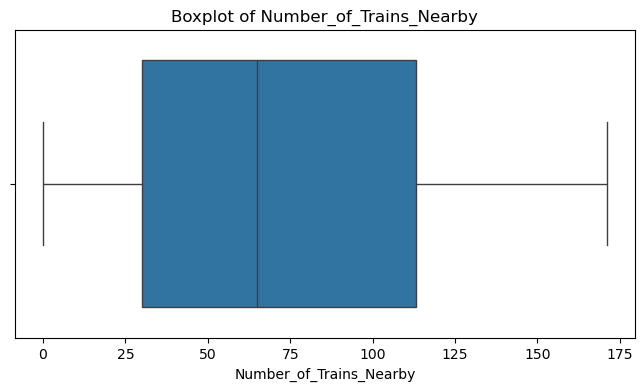

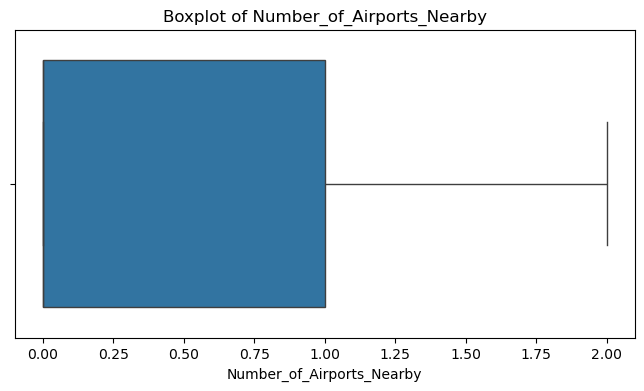

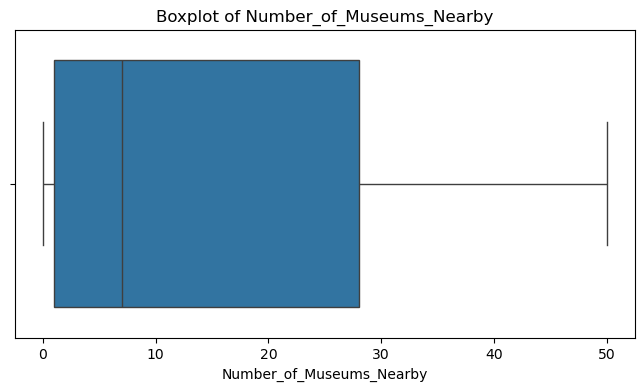

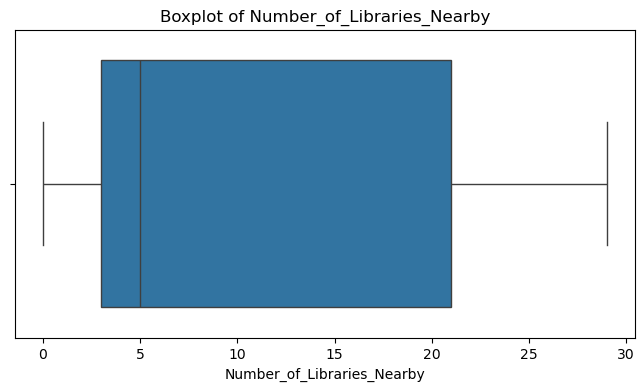

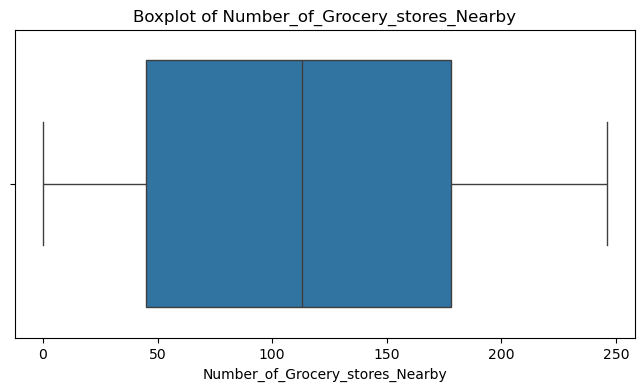

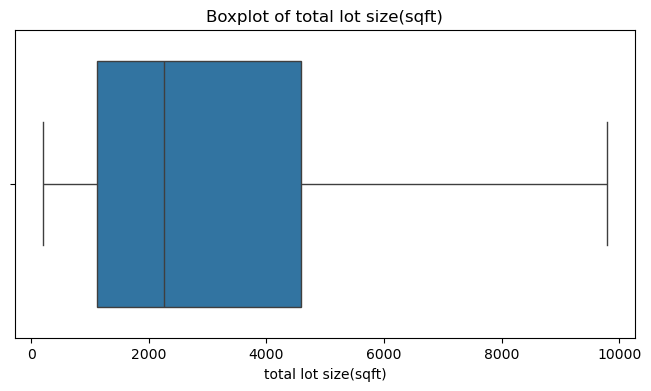

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

plt.show()

## Analyzing Feature Relationships with Property Value
To identify which features most influence property prices, we plot each numeric variable against Property Value. Scatter plots help reveal correlations, outliers, and potential non-linear trends. Strong relationships may become key predictors, while weak or noisy ones could be removal.

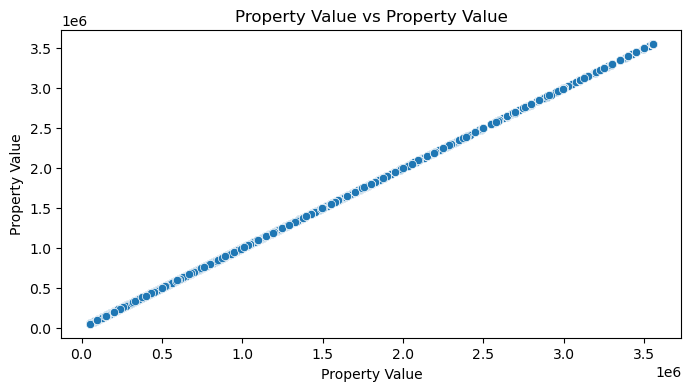

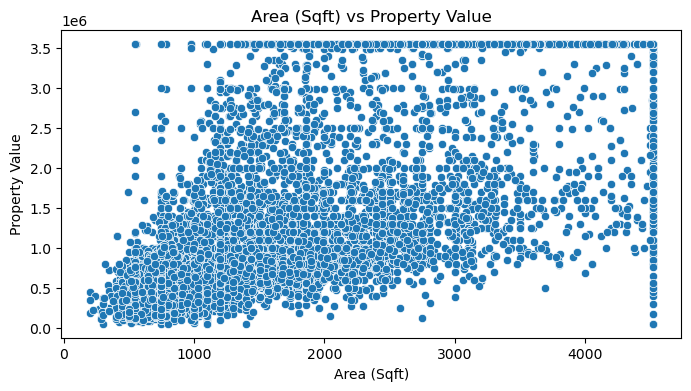

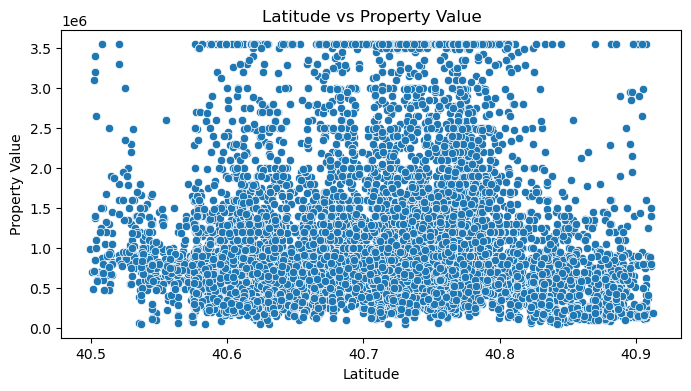

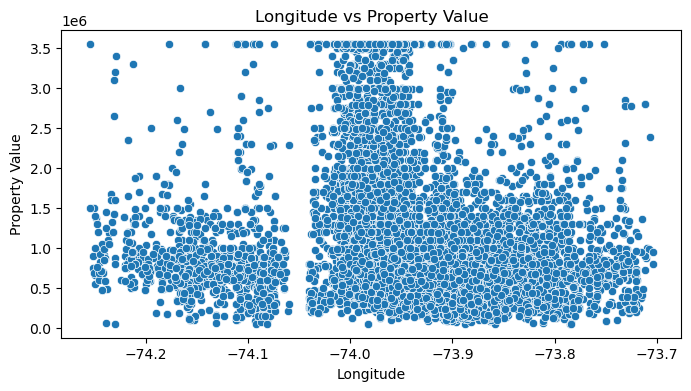

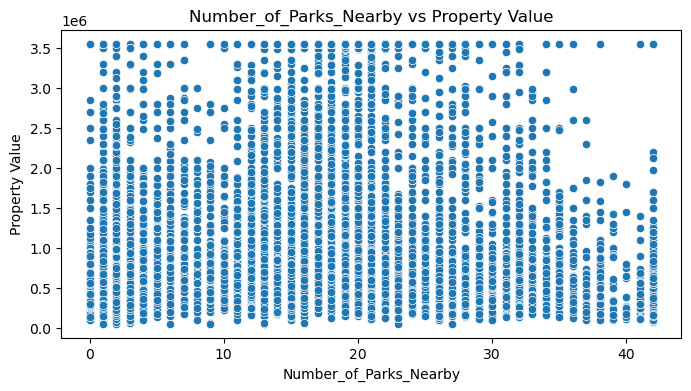

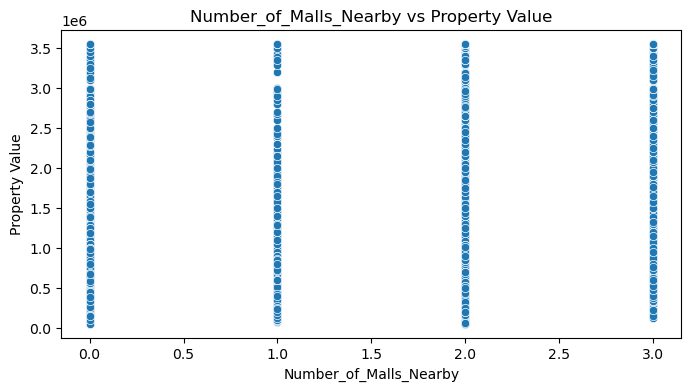

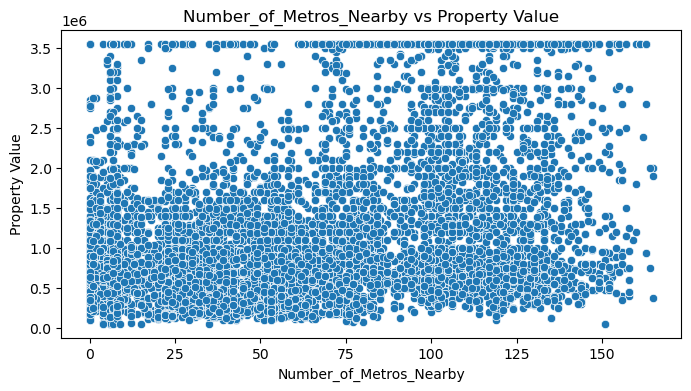

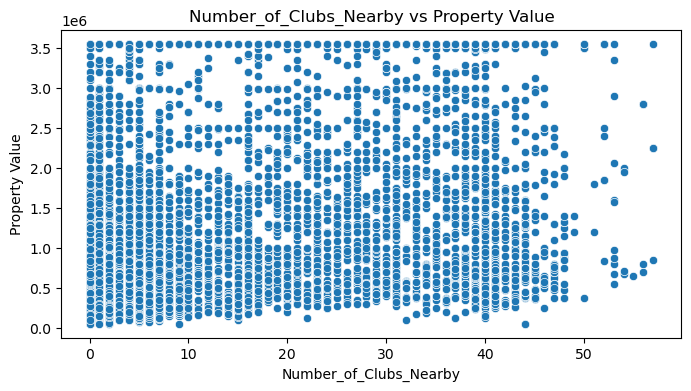

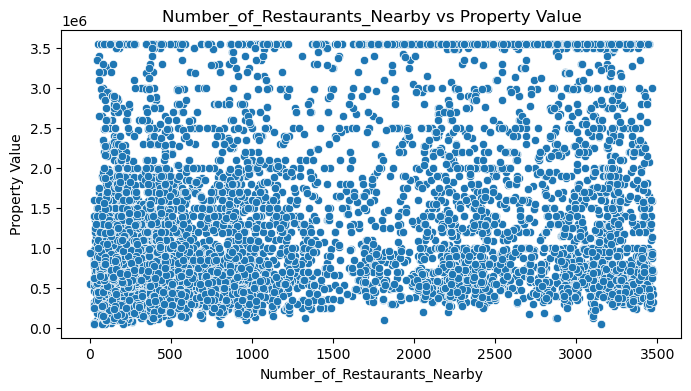

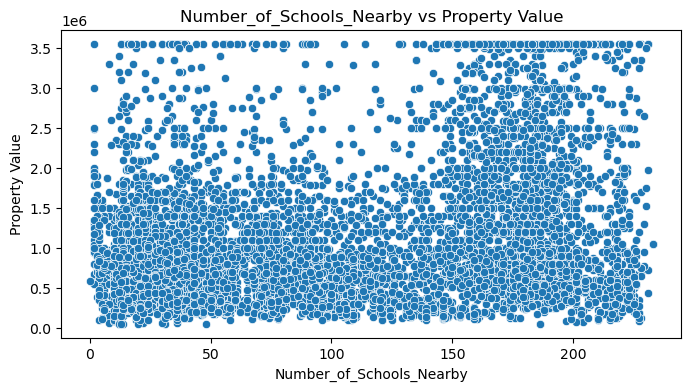

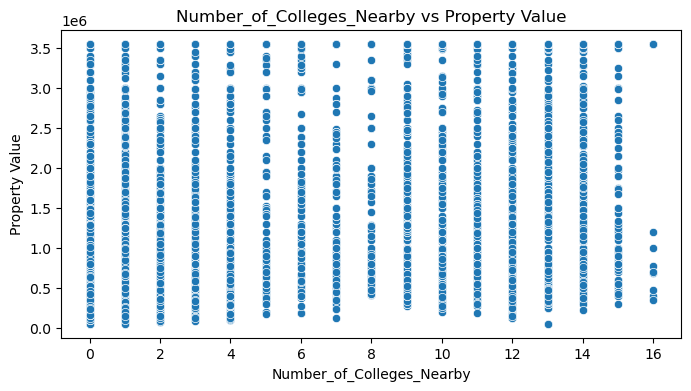

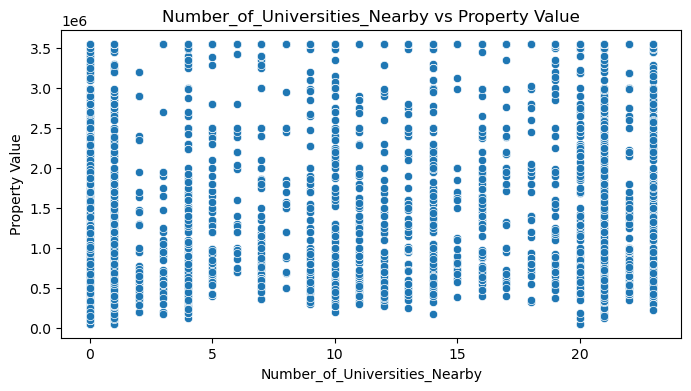

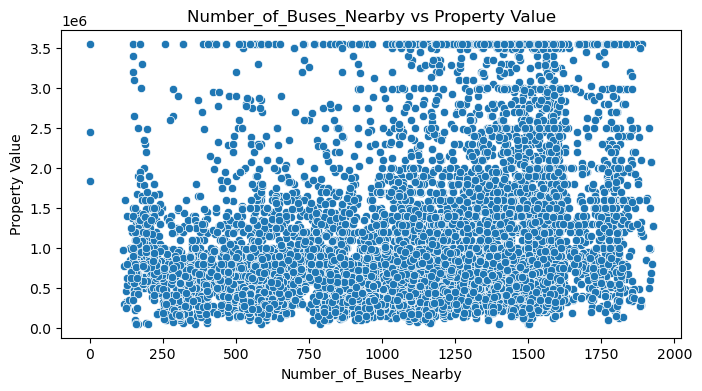

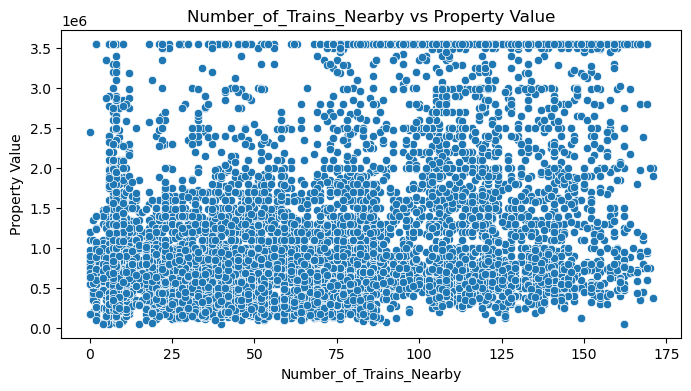

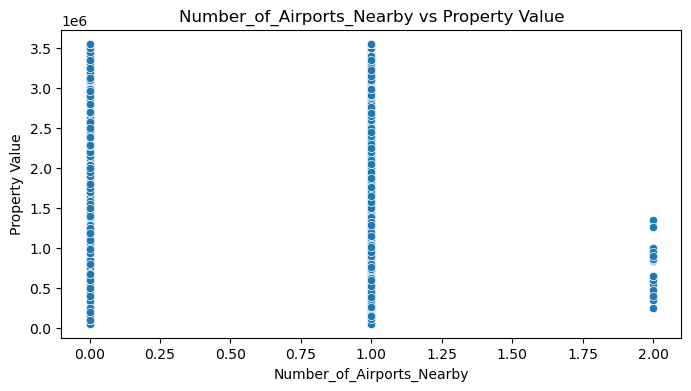

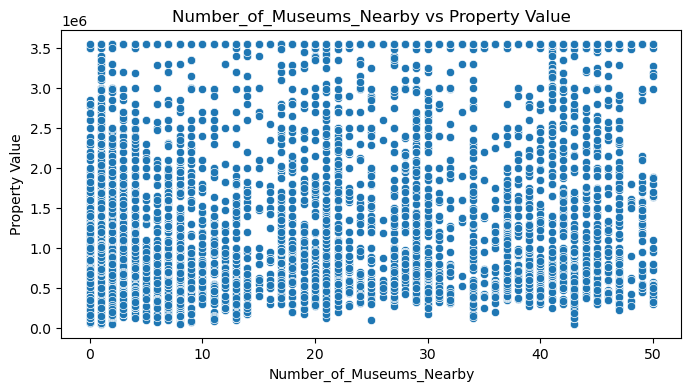

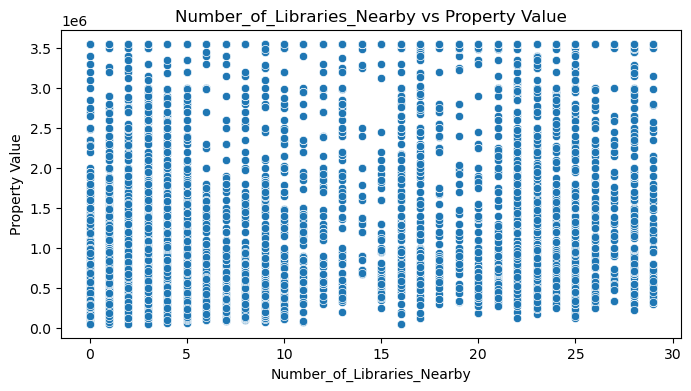

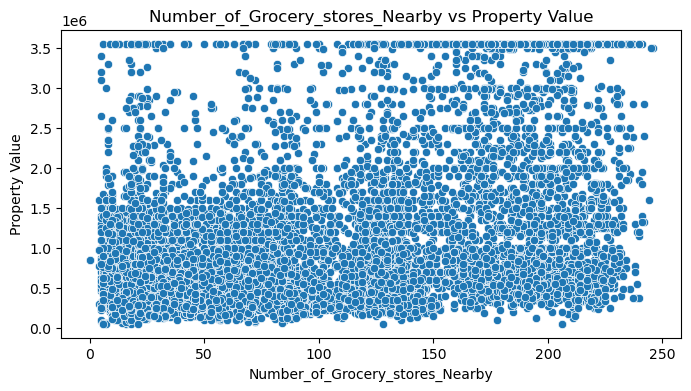

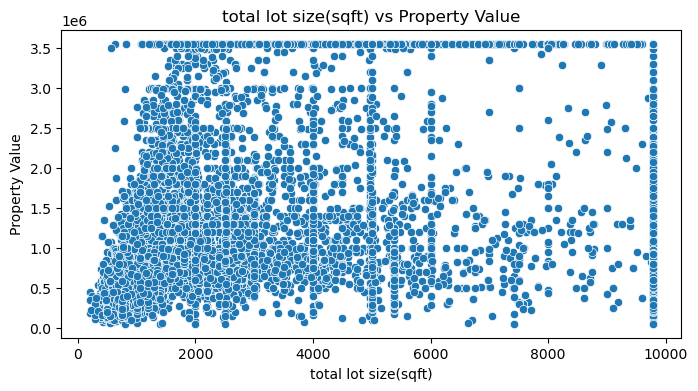

In [166]:

for col in num_cols:
    if col !=  ['Property Value', 'latitude', 'longitude']:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=df[col], y=df['Property Value'])
        plt.title(f'{col} vs Property Value')
        plt.show()

## Analyzing Property Value by Categorical Features
We examine how property values vary across different categories using bar plots. These visualizations help identify which categorical factors (like property type or borough) show significant differences in average home prices. The plots will reveal potential patterns that could be valuable for our predictive model.

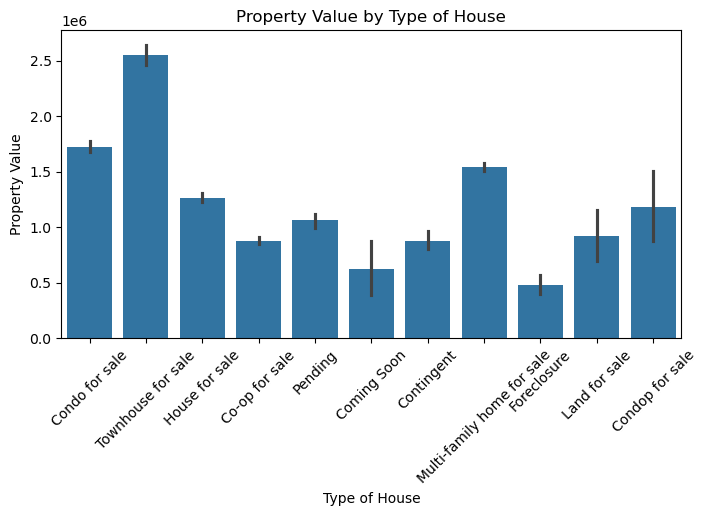

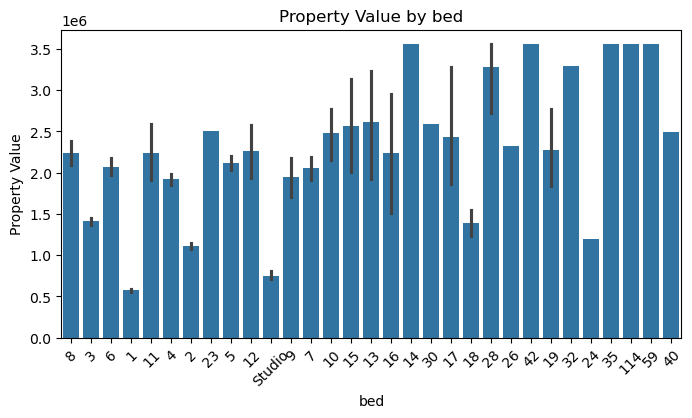

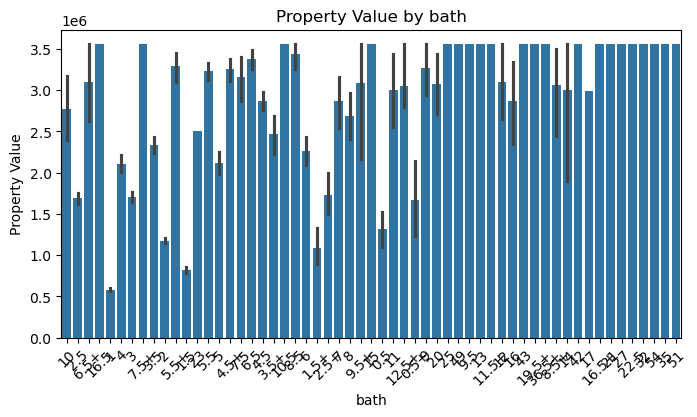

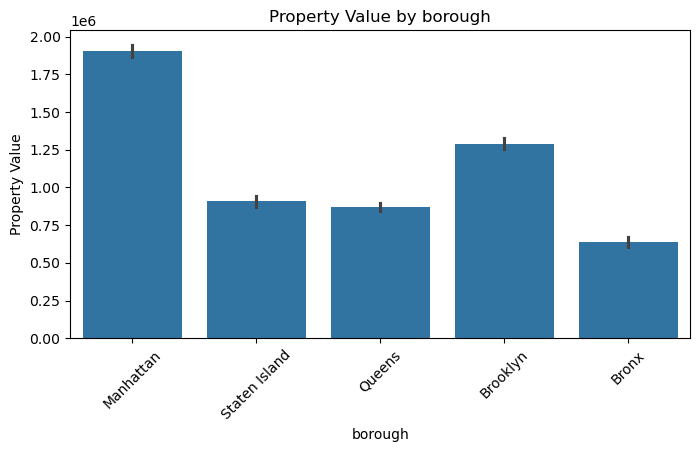

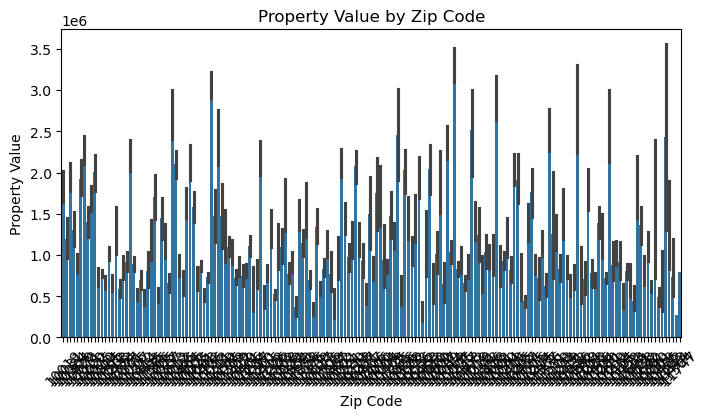

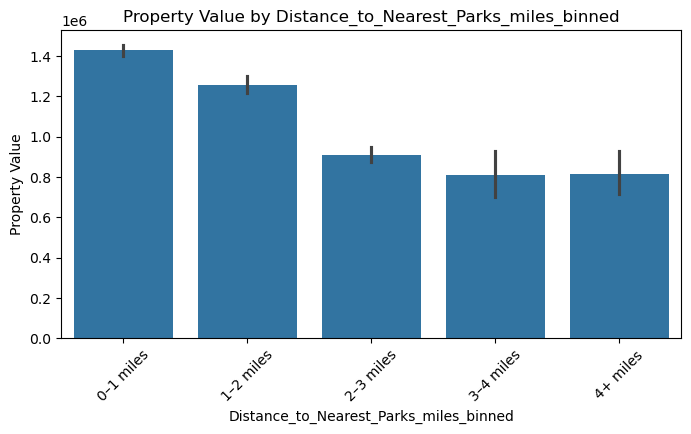

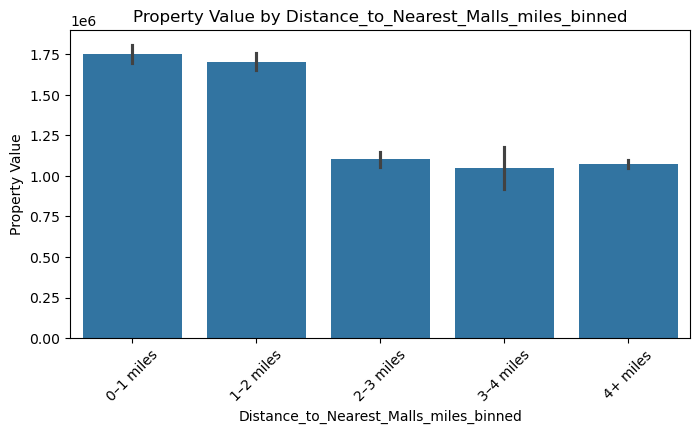

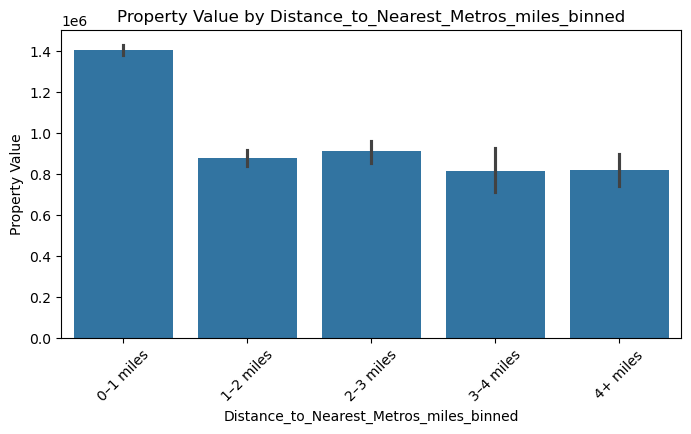

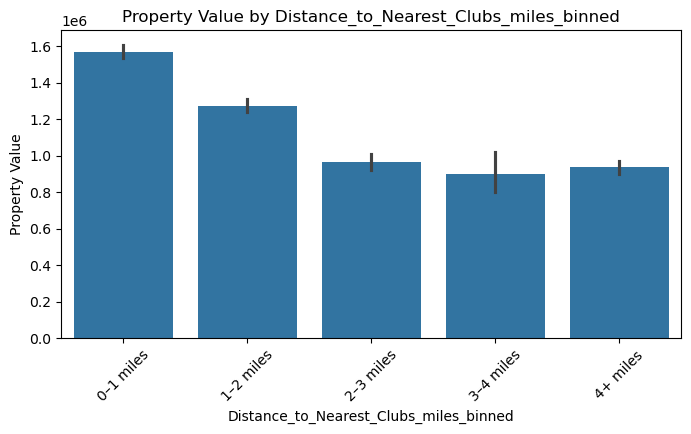

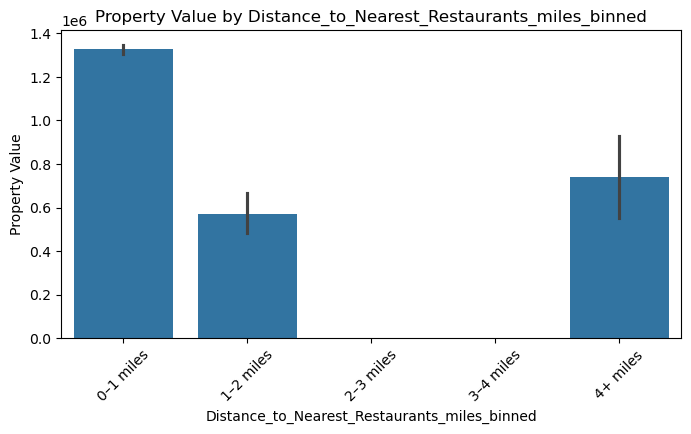

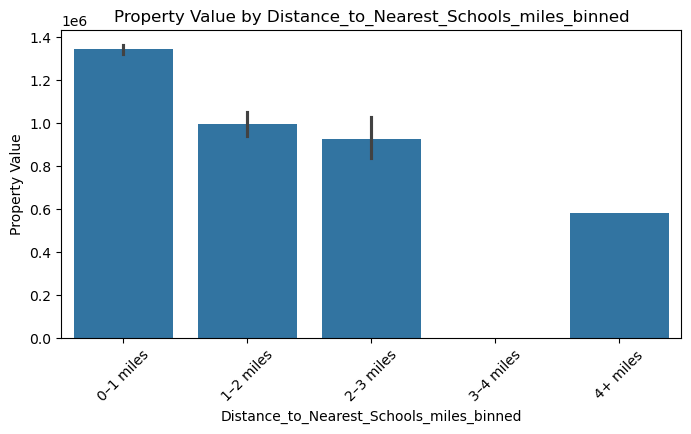

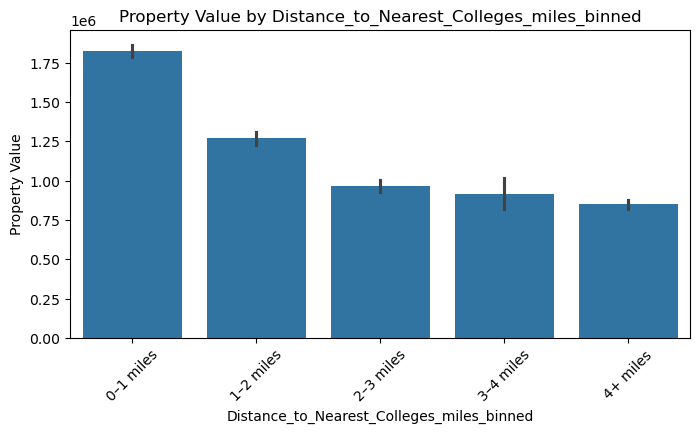

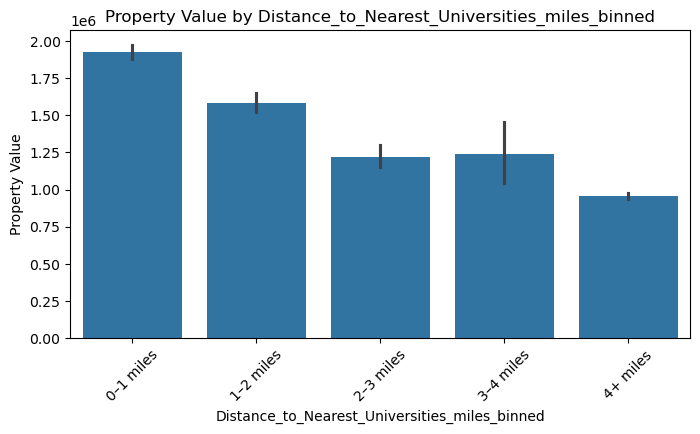

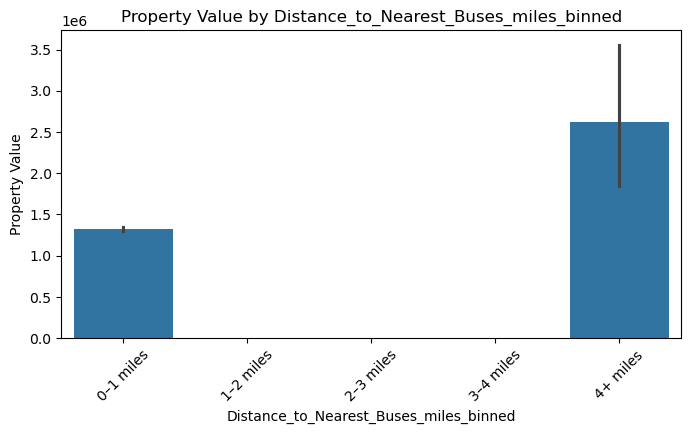

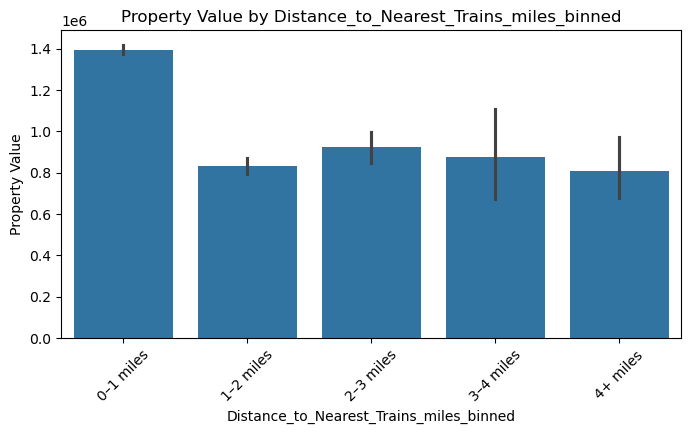

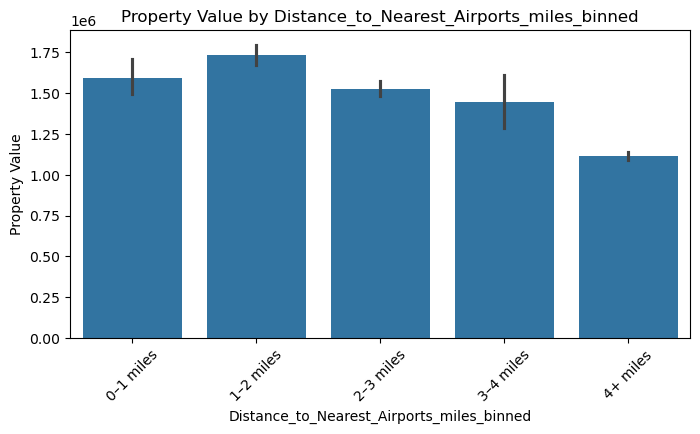

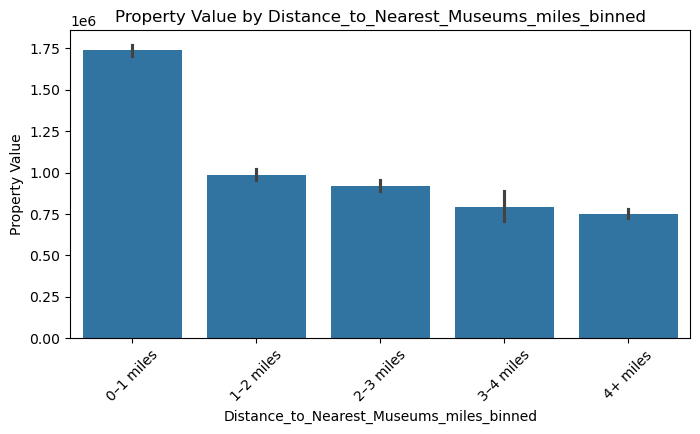

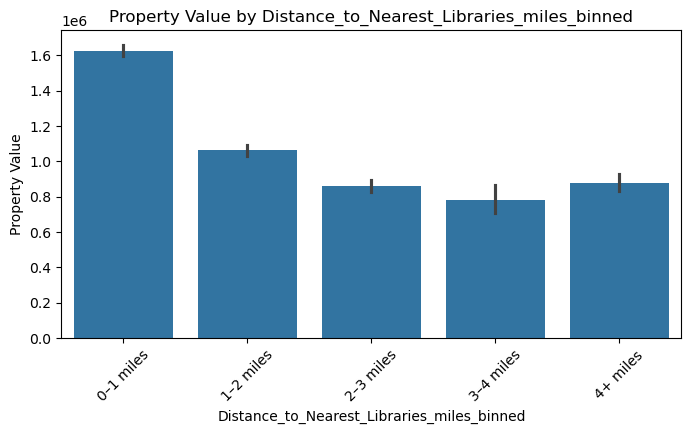

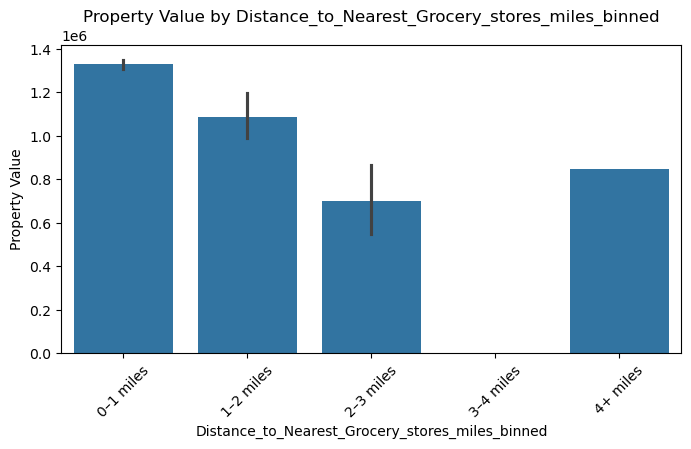

In [167]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=df[col], y=df['Property Value'])
    plt.title(f'Property Value by {col}')
    plt.xticks(rotation=45)
    plt.show()


## Geospatial Analysis of Property Values
This scatter plot visualizes property locations using longitude and latitude coordinates, with color and point size representing property values. The visualization helps identify Geographic price clusters (high-value neighborhoods), Location-based price trends, and Potential spatial patterns that could inform location-based features in our model.

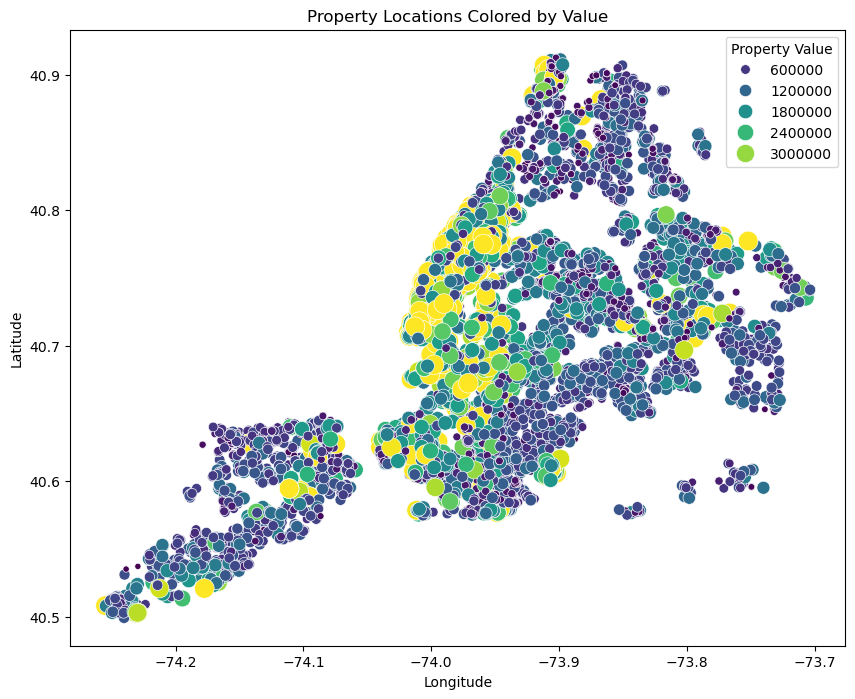

In [168]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Property Value', data=df, 
                palette='viridis', size='Property Value', sizes=(20, 200))
plt.title('Property Locations Colored by Value')
plt.show()

In [169]:
df.shape

(10468, 38)

## Log Transformation and Visualization of Target Variable
Applied a log transformation to the target variable to reduce its right skewness.

<Axes: >

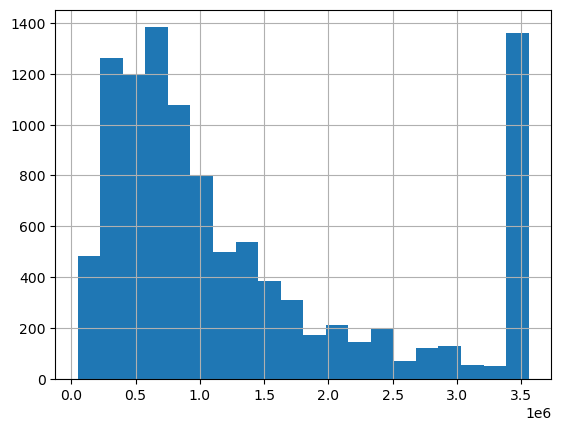

In [170]:
df['Property Value'].hist(bins = 20)

<Axes: >

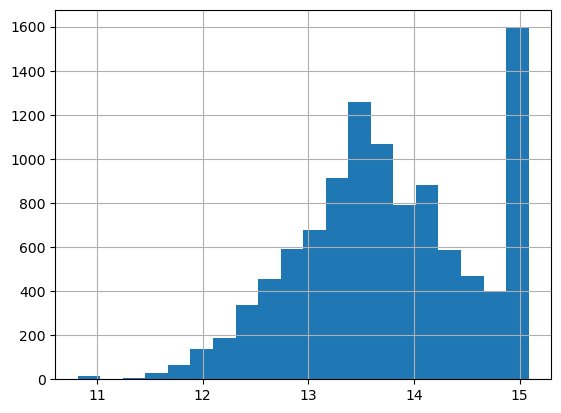

In [171]:
import matplotlib.pyplot as plt
df_encoded['Property Value_log'] = np.log1p(df_encoded['Property Value'])
df_encoded['Property Value_log'].hist(bins = 20)


## Correlation Map
This correlation heatmap focuses only on relationships with coefficients above 0.5, highlighting the strongest positive and negative associations in our dataset. By filtering for these significant correlations, we can identify the redundant features which can be removed, and key predictors that show strong relationships with our target variable (Property Value).

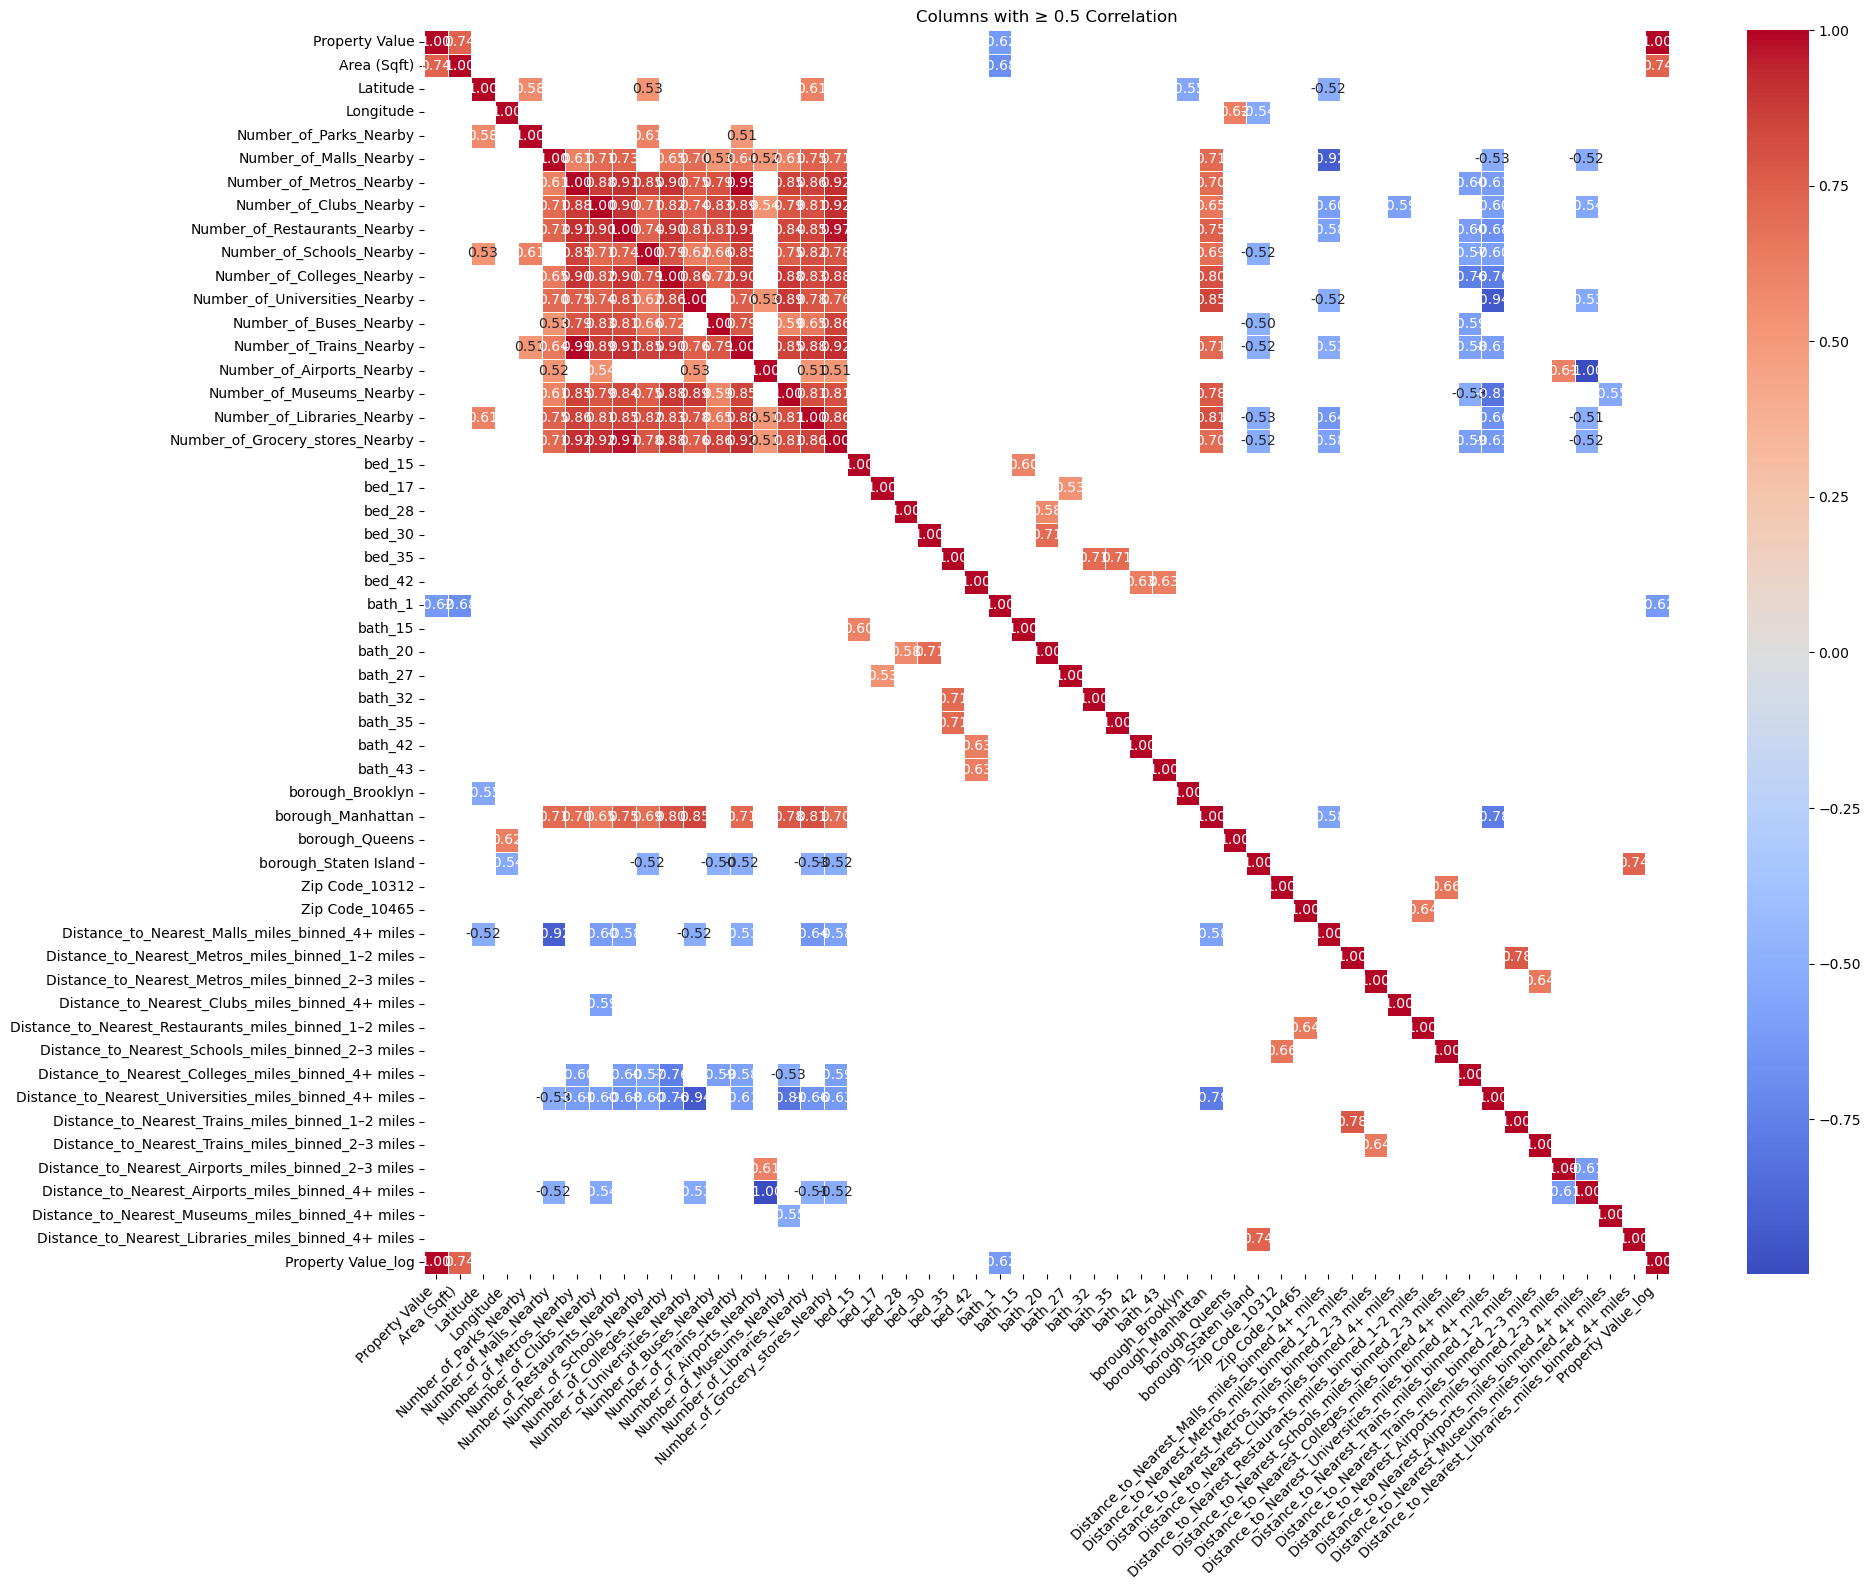

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_encoded.corr(method='spearman')
threshold = 0.5

high_corr_cols = [
    col for col in corr_matrix.columns 
    if ((corr_matrix[col].abs() >= threshold) & (corr_matrix[col] != 1)).any()
]
filtered_corr = corr_matrix.loc[high_corr_cols, high_corr_cols]

plt.figure(figsize=(20, 16))
sns.heatmap(
    filtered_corr,
    annot=True,          
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    mask=(filtered_corr.abs() < threshold)  
)
plt.title(f"Columns with ≥ {threshold} Correlation")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [173]:
df_final = df_encoded.copy()

In [174]:
df_final.drop(columns=["Property Value"], inplace=True)
df_final

Area (Sqft)   Latitude  Longitude  Number_of_Parks_Nearby  \
0         4522.375  40.766474 -73.981266                      16   
1         2431.000  40.826130 -73.943006                      37   
2         4522.375  40.787587 -73.969240                      19   
3         4522.375  40.595008 -74.106434                       1   
4         1556.000  40.675746 -73.822413                      14   
...            ...        ...        ...                     ...   
16607      832.000  40.705254 -74.010340                      17   
16608     1000.000  40.880917 -73.834635                      25   
16609     2750.000  40.689108 -73.913931                      33   
16610     1029.000  40.722400 -73.856690                      12   
16611      545.000  40.740577 -74.008258                      20   

       Number_of_Malls_Nearby  Number_of_Metros_Nearby  \
0                           3                      110   
1                           0                       72   
2                           2                       88   
3                           0                        7   
4                           1                       30   
...                       ...                      ...   
16607                       1                      106   
16608                       0                       24   
16609                       0                       83   
16610                       2                       45   
16611                       3                      117   

       Number_of_Clubs_Nearby  Number_of_Restaurants_Nearby  \
0                          30                          2786   
1                           5                           572   
2                           7                          1933   
3                           1                           173   
4                           7                           252   
...                       ...                           ...   
16607                      29                          2371   
16608                       1                            83   
16609                      24                           817   
16610                      13                           827   
16611                      35                          2972   

       Number_of_Schools_Nearby  Number_of_Colleges_Nearby  ...  \
0                           165                         12  ...   
1                           220                          4  ...   
2                           192                          9  ...   
3                            16                          0  ...   
4                            32                          1  ...   
...                         ...                        ...  ...   
16607                       165                          9  ...   
16608                        72                          1  ...   
16609                       150                          2  ...   
16610                        57                          1  ...   
16611                       150                         14  ...   

       Distance_to_Nearest_Museums_miles_binned_4+ miles  \
0                                                      0   
1                                                      0   
2                                                      0   
3                                                      0   
4                                                      1   
...                                                  ...   
16607                                                  0   
16608                                                  0   
16609                                                  0   
16610                                                  0   
16611                                                  0   

       Distance_to_Nearest_Libraries_miles_binned_1–2 miles  \
0                                                      0      
1                                                      0      
2                    

## Splitting data set

In [175]:
X = df_final.drop(columns=["Property Value_log"])
y = df_final["Property Value_log"]


In [176]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Applying standard scalar

In [177]:
from sklearn.preprocessing import StandardScaler

numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


## Modeling

**Trying RandomForestRegresoor**

In [178]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [179]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")


RMSE: 0.27
R² Score: 0.8998


## Problems & Challenges

## Next steps
safety score

In [180]:
df.columns

Index(['Type of House', 'Property Value', 'bed', 'bath', 'Area (Sqft)',
       'Latitude', 'Longitude', 'Number_of_Parks_Nearby',
       'Number_of_Malls_Nearby', 'Number_of_Metros_Nearby',
       'Number_of_Clubs_Nearby', 'Number_of_Restaurants_Nearby',
       'Number_of_Schools_Nearby', 'Number_of_Colleges_Nearby',
       'Number_of_Universities_Nearby', 'Number_of_Buses_Nearby',
       'Number_of_Trains_Nearby', 'Number_of_Airports_Nearby',
       'Number_of_Museums_Nearby', 'Number_of_Libraries_Nearby',
       'Number_of_Grocery_stores_Nearby', 'borough', 'Zip Code',
       'total lot size(sqft)', 'Distance_to_Nearest_Parks_miles_binned',
       'Distance_to_Nearest_Malls_miles_binned',
       'Distance_to_Nearest_Metros_miles_binned',
       'Distance_to_Nearest_Clubs_miles_binned',
       'Distance_to_Nearest_Restaurants_miles_binned',
       'Distance_to_Nearest_Schools_miles_binned',
       'Distance_to_Nearest_Colleges_miles_binned',
       'Distance_to_Nearest_Universities_mi

In [181]:
import pandas as pd
nypd=pd.read_csv('../NYPD_complaint_data.csv')
# display meta data
print(f"Size of the DataFrame Before removing blank data: {len(nypd)}")
print(nypd[['Latitude','Longitude','OFNS_DESC','PREM_TYP_DESC','CMPLNT_FR_DT','LAW_CAT_CD','ADDR_PCT_CD']].isnull().sum())

# converting the attribute to date time
nypd['CMPLNT_FR_DT'] = pd.to_datetime(nypd['CMPLNT_FR_DT'], errors='coerce')

nypd = nypd[['Latitude','Longitude','OFNS_DESC','PREM_TYP_DESC','CMPLNT_FR_DT','LAW_CAT_CD','ADDR_PCT_CD']]
nypd = nypd.dropna(subset=['Latitude','Longitude','OFNS_DESC','PREM_TYP_DESC','CMPLNT_FR_DT','LAW_CAT_CD','ADDR_PCT_CD'])

print(f"Size of the DataFrame after removing blank data: {len(nypd)}")
print(nypd[['Latitude','Longitude','OFNS_DESC','PREM_TYP_DESC','CMPLNT_FR_DT','LAW_CAT_CD','ADDR_PCT_CD']].isnull().sum())
nypd = nypd[(nypd['CMPLNT_FR_DT'].dt.year >= 2020) & (nypd['CMPLNT_FR_DT'].dt.year <= 2025)]
print(f"Size of the DataFrame after filtering the year: {len(nypd)}")

crime_weights = {
    # Tier 1: Severe Violent Crimes (10)
    'MURDER & NON-NEGL. MANSLAUGHTER': 10,
    'RAPE': 10,
    'FELONY ASSAULT': 10,
    'ROBBERY': 10,
    'KIDNAPPING': 10,
    'KIDNAPPING AND RELATED OFFENSES': 10,
    'HOMICIDE-NEGLIGENT-VEHICLE': 10,
    'HOMICIDE-NEGLIGENT,UNCLASSIFIE': 10,
    
    # Tier 2: Major Property Crimes & Other Serious Offenses (7)
    'BURGLARY': 7,
    'GRAND LARCENY': 7,
    'GRAND LARCENY OF MOTOR VEHICLE': 7,
    'ARSON': 7,
    'DANGEROUS WEAPONS': 7,
    'DANGEROUS DRUGS': 7,
    'SEX CRIMES': 7,
    'FELONY SEX CRIMES': 7,
    'OFFENSES AGAINST THE PERSON': 7,
    
    # Tier 3: Less Severe but Still Significant Crimes (5)
    'PETIT LARCENY': 5,
    'CRIMINAL MISCHIEF & RELATED OF': 5,
    'THEFT-FRAUD': 5,
    'FORGERY': 5,
    'UNAUTHORIZED USE OF A VEHICLE': 5,
    'POSSESSION OF STOLEN PROPERTY': 5,
    'OFFENSES INVOLVING FRAUD': 5,
    'FRAUDS': 5,
    'OTHER OFFENSES RELATED TO THEF': 5,
    
    # Tier 4: Minor Crimes & Violations (3)
    'CRIMINAL TRESPASS': 3,
    'HARRASSMENT 2': 3,
    'INTOXICATED & IMPAIRED DRIVING': 3,
    'DISORDERLY CONDUCT': 3,
    'THEFT OF SERVICES': 3,
    'PETIT LARCENY OF MOTOR VEHICLE': 3,
    'ASSAULT 3 & RELATED OFFENSES': 3,
    'CANNABIS RELATED OFFENSES': 3,
    'INTOXICATED/IMPAIRED DRIVING': 3,
    'PROSTITUTION & RELATED OFFENSES': 3,
    
    # Tier 5: Very Minor Violations (1)
    'LOITERING': 1,
    'GAMBLING': 1,
    'ALCOHOLIC BEVERAGE CONTROL LAW': 1,
    'ADMINISTRATIVE CODE': 1,
    'ADMINISTRATIVE CODES': 1,
    'OTHER STATE LAWS': 1,
    'VEHICLE AND TRAFFIC LAWS': 1,
    'OTHER TRAFFIC INFRACTION': 1,
    'LOITERING/GAMBLING (CARDS, DIC': 1,
    'LOITERING FOR DRUG PURPOSES': 1
}

nypd = nypd[nypd['OFNS_DESC'].isin(crime_weights.keys())]
print(f"Size of the DataFrame after filtering the offence category: {len(nypd)}")



Size of the DataFrame Before removing blank data: 8914838
Latitude         466
Longitude        466
OFNS_DESC          0
PREM_TYP_DESC      0
CMPLNT_FR_DT     655
LAW_CAT_CD         0
ADDR_PCT_CD      771
dtype: int64
Size of the DataFrame after removing blank data: 8913239
Latitude         0
Longitude        0
OFNS_DESC        0
PREM_TYP_DESC    0
CMPLNT_FR_DT     0
LAW_CAT_CD       0
ADDR_PCT_CD      0
dtype: int64
Size of the DataFrame after filtering the year: 1936456
Size of the DataFrame after filtering the offence category: 1774576


In [182]:
# import numpy as np

# import pandas as pd


# # Step 3: Map weights to offense descriptions
# df['CRIME_WEIGHT'] = df['OFNS_DESC'].map(crime_weights).fillna(0)

# # Step 4: Aggregate total crime weight by precinct
# precinct_scores = df.groupby('ADDR_PCT_CD')['CRIME_WEIGHT'].sum().reset_index(name='TOTAL_WEIGHT')

# # Step 5: Extract unique trend info
# trend_info = df[['ADDR_PCT_CD', 'TREND']].drop_duplicates()

# #  6: Merge and apply scoring logic
# df_final = pd.merge(precinct_scores, trend_info, on='ADDR_PCT_CD', how='left')
# df_final['TREND_MULTIPLIER'] = df_final['TREND'].map({'DOWN': 1.25, 'UP': 0.75})
# df_final['RAW_SAFETY_SCORE'] = df_final['TOTAL_WEIGHT'] * df_final['TREND_MULTIPLIER']

# # Step 7: Normalize RAW_SAFETY_SCORE to a scale of 1–100
# min_score = df_final['RAW_SAFETY_SCORE'].min()
# max_score = df_final['RAW_SAFETY_SCORE'].max()
# df_final['SAFETY_SCORE_1_TO_100'] = (
#     1 + 99 * (df_final['RAW_SAFETY_SCORE'] - min_score) / (max_score - min_score)
# ).round(2)

# # Step 8: Sort and save
# df_final = df_final.sort_values(by='SAFETY_SCORE_1_TO_100', ascending=False)
# df_final.to_csv("precinct_safety_score_1_to_100.csv", index=False)

# print("✅ Final safety scores saved as 'precinct_safety_score_1_to_100.csv'")

nypd['SAFETY_SCORE'] = np.random.randint(0, 101, size=len(nypd))


In [183]:
nypd.columns

Index(['Latitude', 'Longitude', 'OFNS_DESC', 'PREM_TYP_DESC', 'CMPLNT_FR_DT',
       'LAW_CAT_CD', 'ADDR_PCT_CD', 'SAFETY_SCORE'],
      dtype='object')

In [184]:
zip_to_precinct={
  "10001": 10,
  "10002": 7,
  "10003": 9,
  "10004": 1,
  "10005": 1,
  "10006": 1,
  "10007": 1,
  "10009": 9,
  "10010": 13,
  "10011": 10,
  "10012": 1,
  "10013": 1,
  "10014": 6,
  "10016": 17,
  "10017": 17,
  "10018": 14,
  "10019": 18,
  "10021": 19,
  "10022": 17,
  "10023": 20,
  "10024": 20,
  "10025": 24,
  "10026": 28,
  "10027": 26,
  "10028": 19,
  "10029": 23,
  "10030": 32,
  "10031": 30,
  "10032": 33,
  "10033": 34,
  "10034": 34,
  "10035": 25,
  "10036": 18,
  "10037": 32,
  "10038": 1,
  "10039": 32,
  "10040": 34,
  "10044": 114,
  "10065": 19,
  "10069": 20,
  "10128": 19,
  "10280": 1,
  "10301": 120,
  "10302": 121,
  "10303": 121,
  "10304": 120,
  "10305": 122,
  "10306": 122,
  "10307": 123,
  "10308": 123,
  "10309": 123,
  "10310": 120,
  "10312": 123,
  "10314": 122,
  "10075": 19,
  "10282": 1,
  "10451": 44,
  "10452": 44,
  "10453": 46,
  "10454": 40,
  "10455": 40,
  "10456": 42,
  "10457": 46,
  "10458": 48,
  "10459": 41,
  "10460": 48,
  "10461": 49,
  "10462": 43,
  "10463": 50,
  "10464": 45,
  "10465": 45,
  "10466": 47,
  "10467": 52,
  "10468": 52,
  "10469": 49,
  "10470": 47,
  "10471": 50,
  "10472": 43,
  "10473": 43,
  "10474": 41,
  "10475": 45,
  "11001": 105,
  "11004": 105,
  "11005": 105,
  "11101": 108,
  "11102": 114,
  "11103": 114,
  "11104": 108,
  "11105": 114,
  "11106": 114,
  "11109": 108,
  "11201": 84,
  "11203": 67,
  "11204": 66,
  "11205": 88,
  "11206": 90,
  "11207": 75,
  "11208": 75,
  "11209": 68,
  "11210": 70,
  "11211": 90,
  "11212": 73,
  "11213": 77,
  "11214": 62,
  "11215": 78,
  "11216": 79,
  "11217": 78,
  "11218": 66,
  "11219": 66,
  "11220": 72,
  "11221": 81,
  "11222": 94,
  "11223": 61,
  "11224": 60,
  "11225": 71,
  "11226": 67,
  "11228": 68,
  "11229": 61,
  "11230": 70,
  "11231": 76,
  "11232": 72,
  "11233": 73,
  "11234": 63,
  "11235": 61,
  "11236": 69,
  "11237": 83,
  "11238": 77,
  "11243": 84,
  "11354": 109,
  "11355": 109,
  "11356": 109,
  "11357": 109,
  "11358": 109,
  "11360": 109,
  "11361": 111,
  "11362": 111,
  "11363": 111,
  "11364": 111,
  "11365": 107,
  "11366": 107,
  "11367": 107,
  "11368": 110,
  "11369": 115,
  "11370": 114,
  "11372": 115,
  "11373": 110,
  "11374": 112,
  "11375": 112,
  "11377": 108,
  "11378": 104,
  "11379": 104,
  "11385": 104,
  "11411": 105,
  "11412": 113,
  "11413": 113,
  "11414": 106,
  "11415": 102,
  "11416": 102,
  "11417": 106,
  "11418": 102,
  "11419": 102,
  "11420": 106,
  "11421": 102,
  "11422": 116,
  "11423": 103,
  "11426": 105,
  "11429": 105,
  "11432": 103,
  "11435": 103,
  "11436": 113,
  "11691": 101,
  "11692": 101,
  "11694": 100,
  "11249":90
}


In [185]:
df['Precinct'] = df['Zip Code'].map(zip_to_precinct).fillna('Unknown')

In [186]:
df.drop(df[df['Precinct'] == 'Unknown'].index)

Type of House  Property Value     bed  bath  Area (Sqft)  \
0                  Condo for sale       3557950.0       8    10     4522.375   
1                  Condo for sale        649000.0       3   2.5     2431.000   
2              Townhouse for sale       3557950.0       6  6.5+     4522.375   
3                  House for sale       3557950.0       8  16.5     4522.375   
4                  House for sale        274000.0       3     1     1556.000   
...                           ...             ...     ...   ...          ...   
16607              Condo for sale       1290000.0       1     1      832.000   
16608               Land for sale        150000.0       2     1     1000.000   
16609  Multi-family home for sale       1190000.0  Studio     1     2750.000   
16610              Co-op for sale        499000.0       2     1     1029.000   
16611              Co-op for sale        765000.0  Studio     1      545.000   

        Latitude  Longitude  Number_of_Parks_Nearby  Number_of_Malls_Nearby  \
0      40.766474 -73.981266                      16                       3   
1      40.826130 -73.943006                      37                       0   
2      40.787587 -73.969240                      19                       2   
3      40.595008 -74.106434                       1                       0   
4      40.675746 -73.822413                      14                       1   
...          ...        ...                     ...                     ...   
16607  40.705254 -74.010340                      17                       1   
16608  40.880917 -73.834635                      25                       0   
16609  40.689108 -73.913931                      33                       0   
16610  40.722400 -73.856690                      12                       2   
16611  40.740577 -74.008258                      20                       3   

       Number_of_Metros_Nearby  ...  Distance_to_Nearest_Schools_miles_binned  \
0                          110  ...                                 0–1 miles   
1                           72  ...                                 0–1 miles   
2                           88  ...                                 0–1 miles   
3                            7  ...                                 0–1 miles   
4                           30  ...                                 0–1 miles   
...                        ...  ...                                       ...   
16607                      106  ...                                 0–1 miles   
16608                       24  ...                                 0–1 miles   
16609                       83  ...                                 0–1 miles   
16610                       45  ...                                 0–1 miles   
16611                      117  ...                                 0–1 miles   

       Distance_to_Nearest_Colleges_miles_binned  \
0                                      0–1 miles   
1                                      0–1 miles   
2                                      1–2 miles   
3                                       4+ miles   
4                                      2–3 miles   
...                                          ...   
16607                                  0–1 miles   
16608                                  2–3 miles   
16609                                  1–2 miles   
16610                                  1–2 miles   
16611                                  0–1 miles   

       Distance_to_Nearest_Universities_miles_binned  \
0                                          0–1 miles   
1                                          0–1 miles   
2                                          1–2 miles   
3                                          1–2 miles   
4                                           4+ miles   
...                                              ...   
16607                                      1–2 miles   
16608                                       4+ miles   
16609   

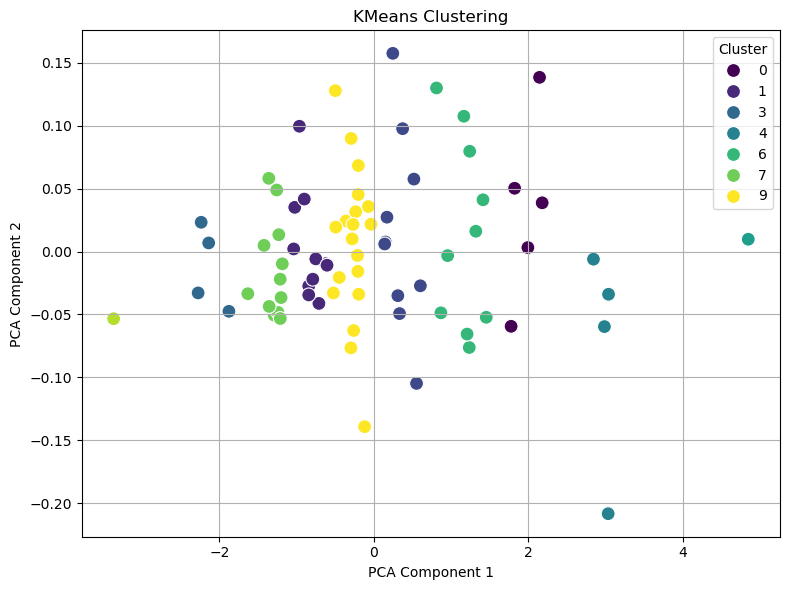

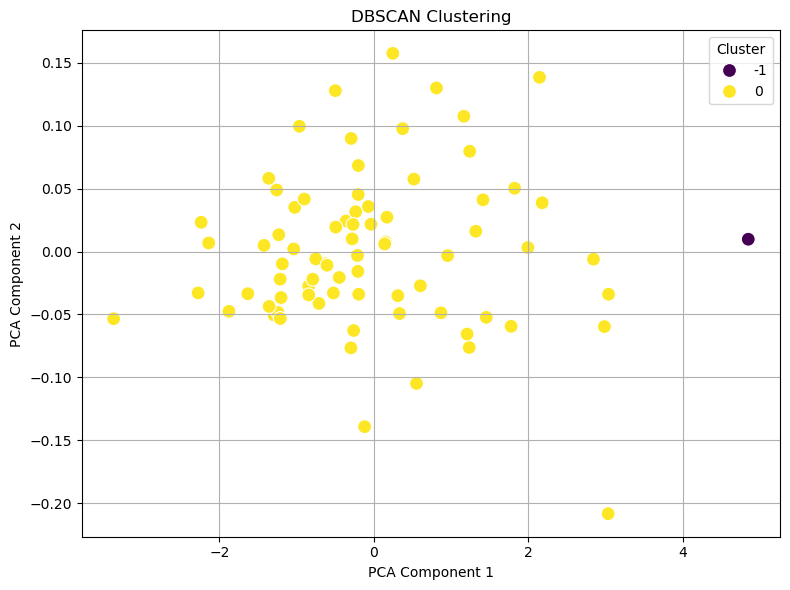

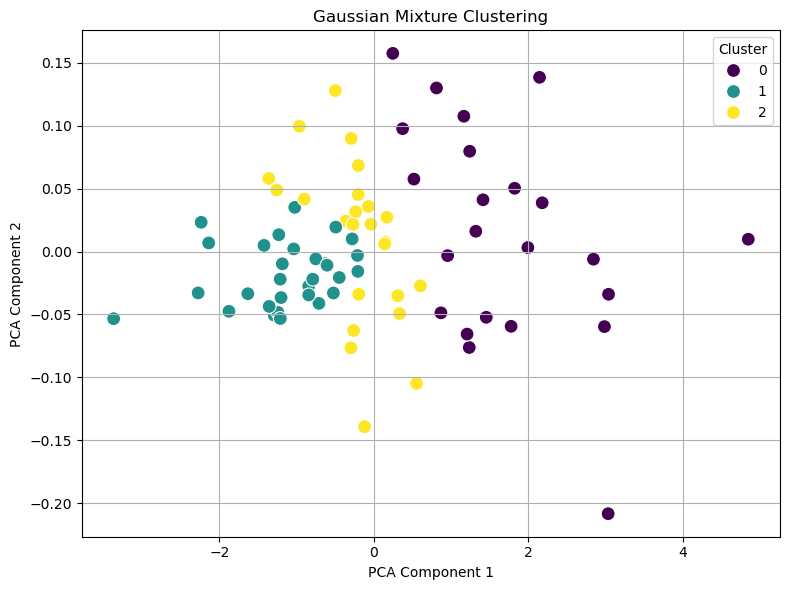

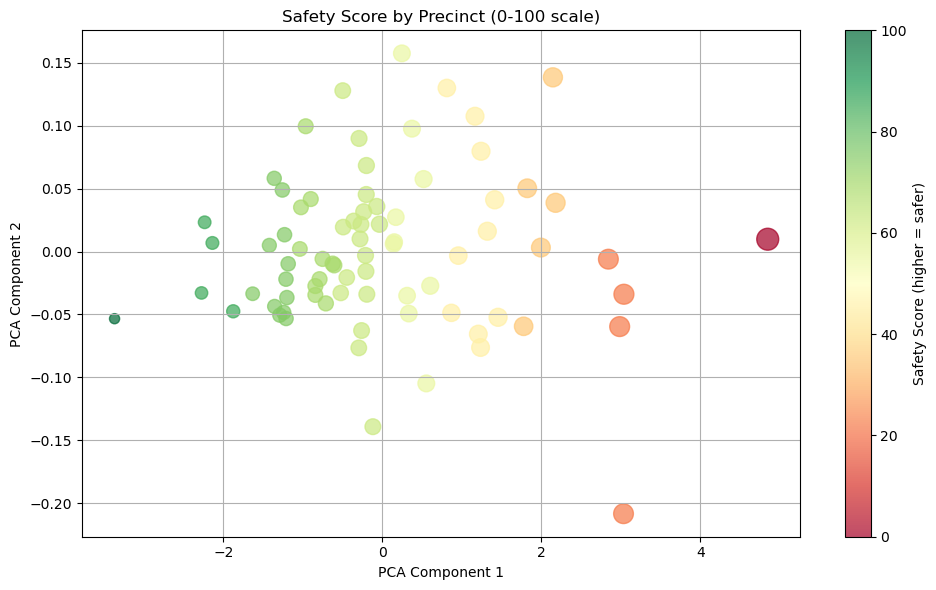

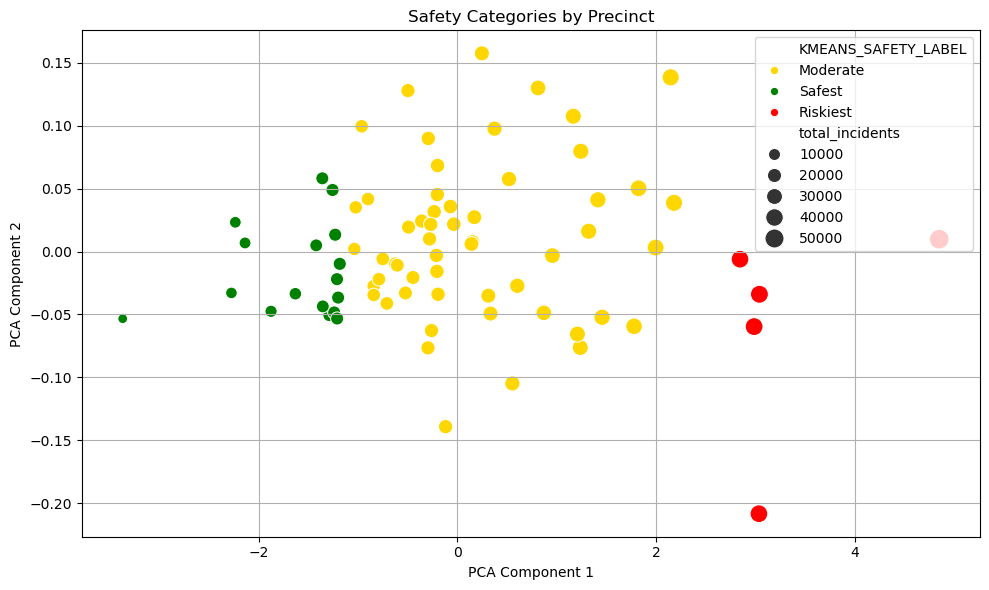

✅ File saved: 'precinct_clustering_output_with_safety.csv'
✓ Safety scores normalized to 0-100 scale (higher = safer)


In [187]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define crime weights
crime_weights = {
    'MURDER & NON-NEGL. MANSLAUGHTER': 10, 'RAPE': 10, 'FELONY ASSAULT': 10,
    'ROBBERY': 10, 'KIDNAPPING': 10, 'KIDNAPPING AND RELATED OFFENSES': 10,
    'HOMICIDE-NEGLIGENT-VEHICLE': 10, 'HOMICIDE-NEGLIGENT,UNCLASSIFIE': 10,
    'BURGLARY': 7, 'GRAND LARCENY': 7, 'GRAND LARCENY OF MOTOR VEHICLE': 7,
    'ARSON': 7, 'DANGEROUS WEAPONS': 7, 'DANGEROUS DRUGS': 7,
    'SEX CRIMES': 7, 'FELONY SEX CRIMES': 7, 'OFFENSES AGAINST THE PERSON': 7,
    'PETIT LARCENY': 5, 'CRIMINAL MISCHIEF & RELATED OF': 5, 'THEFT-FRAUD': 5,
    'FORGERY': 5, 'UNAUTHORIZED USE OF A VEHICLE': 5,
    'POSSESSION OF STOLEN PROPERTY': 5, 'OFFENSES INVOLVING FRAUD': 5,
    'FRAUDS': 5, 'OTHER OFFENSES RELATED TO THEF': 5,
    'CRIMINAL TRESPASS': 3, 'HARRASSMENT 2': 3, 'INTOXICATED & IMPAIRED DRIVING': 3,
    'DISORDERLY CONDUCT': 3, 'THEFT OF SERVICES': 3,
    'PETIT LARCENY OF MOTOR VEHICLE': 3, 'ASSAULT 3 & RELATED OFFENSES': 3,
    'CANNABIS RELATED OFFENSES': 3, 'INTOXICATED/IMPAIRED DRIVING': 3,
    'PROSTITUTION & RELATED OFFENSES': 3,
    'LOITERING': 1, 'GAMBLING': 1, 'ALCOHOLIC BEVERAGE CONTROL LAW': 1,
    'ADMINISTRATIVE CODE': 1, 'ADMINISTRATIVE CODES': 1, 'OTHER STATE LAWS': 1,
    'VEHICLE AND TRAFFIC LAWS': 1, 'OTHER TRAFFIC INFRACTION': 1,
    'LOITERING/GAMBLING (CARDS, DIC': 1, 'LOITERING FOR DRUG PURPOSES': 1
}

# Step 1: Map crime weights
nypd['CRIME_WEIGHT'] = nypd['OFNS_DESC'].map(crime_weights).fillna(0)

# Step 2: Aggregate per precinct
agg_df = nypd.groupby('ADDR_PCT_CD').agg(
    total_weight=('CRIME_WEIGHT', 'sum'),
    total_incidents=('OFNS_DESC', 'count'),
    Latitude=('Latitude', 'mean'),
    Longitude=('Longitude', 'mean')
).reset_index()

# Step 3: Feature scaling
features = agg_df[['total_weight', 'total_incidents']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 4: PCA for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
agg_df['PCA1'], agg_df['PCA2'] = components[:, 0], components[:, 1]

# Step 5: Clustering models
agg_df['KMeans_Cluster'] = KMeans(n_clusters=10, random_state=42).fit_predict(X_scaled)
agg_df['DBSCAN_Cluster'] = DBSCAN(eps=1.2, min_samples=3).fit_predict(X_scaled)
agg_df['GMM_Cluster'] = GaussianMixture(n_components=3, random_state=42).fit_predict(X_scaled)

# Step 6: Calculate raw safety scores using the new logic
# Calculate mean crime weight per cluster
cluster_stats = agg_df.groupby('KMeans_Cluster')['total_weight'].mean()
# Map each precinct to its cluster's mean crime weight
agg_df['CLUSTER_MEAN_WEIGHT'] = agg_df['KMeans_Cluster'].map(cluster_stats)
# Min-max scaling to 0-100 range (higher = safer)
min_weight = agg_df['CLUSTER_MEAN_WEIGHT'].min()
max_weight = agg_df['CLUSTER_MEAN_WEIGHT'].max()
range_weight = max_weight - min_weight
# Invert the scale so higher values = safer areas
agg_df['SAFETY_SCORE_0_100'] = 100 * (max_weight - agg_df['CLUSTER_MEAN_WEIGHT']) / range_weight

# Step 7: Assign human-readable labels based on safety score
def assign_safety_label(score):
    if score >= 70:
        return 'Safest'
    elif score >= 30:
        return 'Moderate'
    else:
        return 'Riskiest'

agg_df['KMEANS_SAFETY_LABEL'] = agg_df['SAFETY_SCORE_0_100'].apply(assign_safety_label)

# Step 8: Visualization function
def plot_clusters(data, cluster_col, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x='PCA1', y='PCA2', hue=cluster_col, palette='viridis', s=100)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 9: Visualize clusters
plot_clusters(agg_df, 'KMeans_Cluster', 'KMeans Clustering')
plot_clusters(agg_df, 'DBSCAN_Cluster', 'DBSCAN Clustering')
plot_clusters(agg_df, 'GMM_Cluster', 'Gaussian Mixture Clustering')

# Step 10: Visualize safety scores (FIXED)
plt.figure(figsize=(10, 6))
# Create a scatter plot with a colormap
scatter = plt.scatter(
    agg_df['PCA1'], 
    agg_df['PCA2'], 
    c=agg_df['SAFETY_SCORE_0_100'],
    cmap='RdYlGn',  # Red-Yellow-Green colormap
    s=agg_df['total_incidents'] / agg_df['total_incidents'].max() * 200 + 50,  # Size based on incidents
    alpha=0.7
)
plt.title('Safety Score by Precinct (0-100 scale)')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
# Now colorbar will work correctly
cbar = plt.colorbar(scatter)
cbar.set_label('Safety Score (higher = safer)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 11: Alternative visualization - Safety label categories
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg_df, 
    x='PCA1', 
    y='PCA2', 
    hue='KMEANS_SAFETY_LABEL',
    palette={'Safest': 'green', 'Moderate': 'gold', 'Riskiest': 'red'},
    size='total_incidents',
    sizes=(50, 200)
)
plt.title('Safety Categories by Precinct')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 12: Save final output
agg_df.to_csv("precinct_clustering_output_with_safety.csv", index=False)
print("✅ File saved: 'precinct_clustering_output_with_safety.csv'")
print("✓ Safety scores normalized to 0-100 scale (higher = safer)")

In [188]:
safety = pd.read_csv('./precinct_clustering_output_with_safety.csv')

print("Safety type",(safety['ADDR_PCT_CD']).dtype)
df=df[df['Precinct'] != "Unknown"]
print("Safety type",(df['Precinct'].astype(float)).dtype)

Safety type float64
Safety type float64


In [189]:
df = df.merge(
    safety[['ADDR_PCT_CD', 'SAFETY_SCORE_0_100']],
    how='left',
    left_on='Precinct',
    right_on='ADDR_PCT_CD'
)

df = df.drop(columns='ADDR_PCT_CD')
df = df.rename(columns={'SAFETY_SCORE_0_100': 'Safety_Score'})


In [190]:
print("shape of df: ",df.shape)
print("columns in df: ",df.columns)

shape of df:  (10465, 40)
columns in df:  Index(['Type of House', 'Property Value', 'bed', 'bath', 'Area (Sqft)',
       'Latitude', 'Longitude', 'Number_of_Parks_Nearby',
       'Number_of_Malls_Nearby', 'Number_of_Metros_Nearby',
       'Number_of_Clubs_Nearby', 'Number_of_Restaurants_Nearby',
       'Number_of_Schools_Nearby', 'Number_of_Colleges_Nearby',
       'Number_of_Universities_Nearby', 'Number_of_Buses_Nearby',
       'Number_of_Trains_Nearby', 'Number_of_Airports_Nearby',
       'Number_of_Museums_Nearby', 'Number_of_Libraries_Nearby',
       'Number_of_Grocery_stores_Nearby', 'borough', 'Zip Code',
       'total lot size(sqft)', 'Distance_to_Nearest_Parks_miles_binned',
       'Distance_to_Nearest_Malls_miles_binned',
       'Distance_to_Nearest_Metros_miles_binned',
       'Distance_to_Nearest_Clubs_miles_binned',
       'Distance_to_Nearest_Restaurants_miles_binned',
       'Distance_to_Nearest_Schools_miles_binned',
       'Distance_to_Nearest_Colleges_miles_binned',
 

In [191]:
df.to_csv("Fully_cleaned.csv", index=False)
print("✅ File saved")


✅ File saved


## Deep Neural Networks

In [227]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ----------  1: Load and Prep Data ----------
# df = pd.read_csv("your_data.csv")

target = 'Property Value'
# Separate numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Separate categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

X = df[categorical_cols + numerical_cols]
y = df[target]

# ---------- Step 2: Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- Step 3: Preprocessing with OneHot and Scaling ----------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit-transform the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

input_dim = X_train_processed.shape[1]

# ---------- Step 4: Build the Model ----------
model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

# ---------- Step 5: Train the Model ----------
history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=500,
    batch_size=32,
    verbose=1
)

# ---------- Step 6: Evaluate ----------
loss, mae = model.evaluate(X_test_processed, y_test)
print(f"Test MAE: {mae:.2f}")

# ---------- Optional: Predict ----------
predictions = model.predict(X_test_processed)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions
# predictions = model.predict(X_test_processed)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Model Evaluation Metrics:")
print(f"--------------------------")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


ValueError: Selected columns, ['Property Value', 'Area (Sqft)', 'Latitude', 'Longitude', 'Number_of_Parks_Nearby', 'Number_of_Malls_Nearby', 'Number_of_Metros_Nearby', 'Number_of_Clubs_Nearby', 'Number_of_Restaurants_Nearby', 'Number_of_Schools_Nearby', 'Number_of_Colleges_Nearby', 'Number_of_Universities_Nearby', 'Number_of_Buses_Nearby', 'Number_of_Trains_Nearby', 'Number_of_Airports_Nearby', 'Number_of_Museums_Nearby', 'Number_of_Libraries_Nearby', 'Number_of_Grocery_stores_Nearby', 'total lot size(sqft)', 'Precinct', 'Safety_Score', 'Safety_Score'], are not unique in dataframe

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ---------- Step 1: Load and Prep Data ----------
target = 'Property Value'

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from features
numerical_cols = [col for col in numerical_cols if col != target]
X = df[categorical_cols + numerical_cols]
y = df[target]


# ---------- Step 3: Train-Test Split ----------
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- Step 4: Preprocessing ----------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

input_dim = X_train_processed.shape[1]

# ---------- Step 5: Building the Model ----------
model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=15, restore_best_weights=True)

# ---------- Step 6: Train the Model ----------
history = model.fit(
    X_train_processed, y_train_log,
    validation_data=(X_test_processed, y_test_log),
    epochs=50,
    batch_size=32,
    verbose=1
)

# ---------- Step 7: Predict & Inverse Transform ----------
predictions_log = model.predict(X_test_processed)
predictions = np.expm1(predictions_log).flatten()  # Back to original scale
y_actual = np.expm1(y_test_log).values

# ---------- Step 8: Evaluation ----------
mae = mean_absolute_error(y_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_actual, predictions))
r2 = r2_score(y_actual, predictions)

print(f"\nModel Evaluation Metrics (original scale):")
print(f"------------------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# ---------- Step 9: Optional Plot ----------
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, predictions, alpha=0.3)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")
plt.title("Actual vs Predicted (DNN + Log Transform)")
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │        55,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,177 (258.50 KB)

 Trainable params: 65,921 (257.50 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2977460387840.0000 - mae: 1341130.0000 - val_loss: 3009387692032.0000 - val_mae: 1348754.2500
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2888986525696.0000 - mae: 1306127.0000 - val_loss: 2566011486208.0000 - val_mae: 1174699.6250
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2211044130816.0000 - mae: 1042847.0625 - val_loss: 1480507129856.0000 - val_mae: 821583.3750
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1328371597312.0000 - mae: 817012.1875 - val_loss: 1200417931264.0000 - val_mae: 859684.1875
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1174605791232.0000 - mae: 865379.4375 - val_loss: 1192914190336.0000 - val_mae: 872405.1875
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1179818655744.0000 - mae: 869561.0625 - val_loss: 1192995192832.0000 - val_mae: 872178.1250
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1194867032064.0000 - ma

ValueError: Input contains infinity or a value too large for dtype('float64').

## SKlearn

Iteration 1, loss = 1424542181489.26391602
Validation score: -1.351148
Iteration 2, loss = 829929883785.26074219
Validation score: 0.217580
Iteration 3, loss = 358289472022.29284668
Validation score: 0.398765
Iteration 4, loss = 299001409375.30664062
Validation score: 0.492360
Iteration 5, loss = 252978124609.21029663
Validation score: 0.573657
Iteration 6, loss = 212216728600.21786499
Validation score: 0.642790
Iteration 7, loss = 179931825986.33590698
Validation score: 0.697565
Iteration 8, loss = 155423393168.63641357
Validation score: 0.735941
Iteration 9, loss = 138521805197.23004150
Validation score: 0.760664
Iteration 10, loss = 127135818426.69723511
Validation score: 0.779180
Iteration 11, loss = 118583786418.21734619
Validation score: 0.790211
Iteration 12, loss = 112073331604.82582092
Validation score: 0.799082
Iteration 13, loss = 107578016263.08520508
Validation score: 0.804738
Iteration 14, loss = 104699024813.94987488
Validation score: 0.807976
Iteration 15, loss = 102699

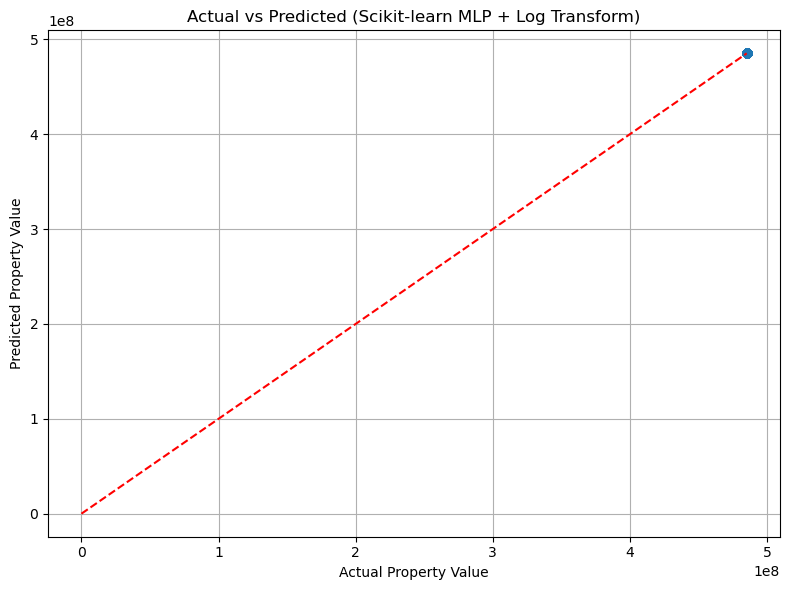

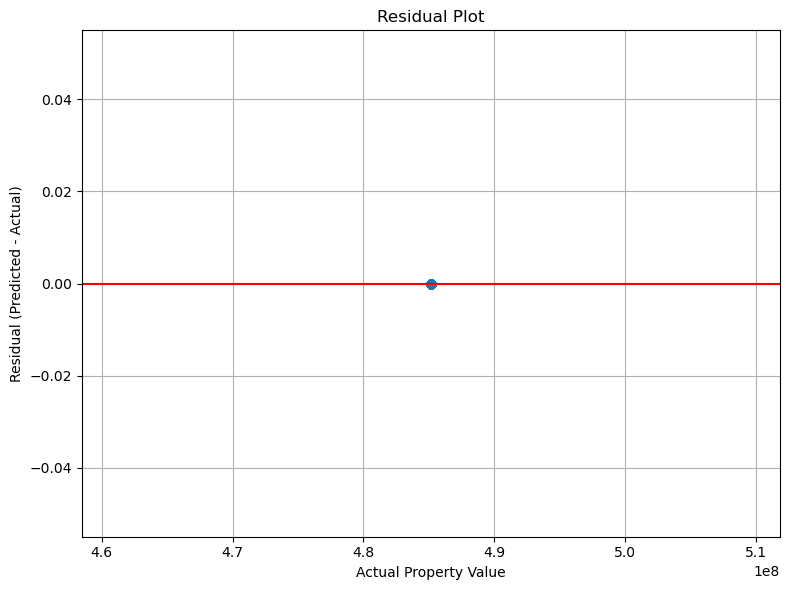

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---------- Step 1: Load and Prep Data ----------
target = 'Property Value'

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from features
numerical_cols = [col for col in numerical_cols if col != target]
X = df[categorical_cols + numerical_cols]
y = df[target]

# ---------- Step 2: Train-Test Split ----------
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- Step 3: Create a Pipeline with Preprocessing and Model ----------
# Define the preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Define the MLPRegressor (similar structure to the Keras model)
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),  # Matches the Keras architecture
    activation='relu',                 # Same activation as Keras
    solver='adam',                     # Adam optimizer
    alpha=0.0001,                      # L2 regularization (similar to weight decay)
    batch_size=32,                     # Same batch size
    learning_rate_init=0.001,          # Same learning rate
    max_iter=50,                       # Equivalent to epochs
    early_stopping=True,               # Similar to EarlyStopping callback
    validation_fraction=0.1,           # For early stopping
    n_iter_no_change=15,               # Similar to patience in EarlyStopping
    random_state=42,
    verbose=True
)

# Create a pipeline that combines preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', mlp)
])

# ---------- Step 4: Train the Model ----------
pipeline.fit(X_train, y_train_log)

# ---------- Step 5: Predict & Inverse Transform ----------
predictions_log = pipeline.predict(X_test)

# Ensure no extreme values before applying inverse transformation
# Clip predictions to prevent extreme values after expm1
max_safe_value = 20  # log(e^20) is a reasonably large value
predictions_log_clipped = np.clip(predictions_log, None, max_safe_value)

# Apply inverse transformation
predictions = np.expm1(predictions_log_clipped)

# Also handle the actual values to ensure we don't have infinity
y_test_log_np = np.array(y_test_log)
y_test_log_clipped = np.clip(y_test_log_np, None, max_safe_value)
y_actual = np.expm1(y_test_log_clipped)

# ---------- Step 6: Evaluation ----------
# Check for and handle any remaining infinite values
predictions = np.nan_to_num(predictions, nan=0.0, posinf=np.finfo(np.float64).max, neginf=0)
y_actual = np.nan_to_num(y_actual, nan=0.0, posinf=np.finfo(np.float64).max, neginf=0)

mae = mean_absolute_error(y_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_actual, predictions))
r2 = r2_score(y_actual, predictions)

print(f"\nModel Evaluation Metrics (original scale):")
print(f"------------------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# ---------- Step 7: Optional Plot ----------
# Filter out any extreme values for plotting
max_plot_value = np.percentile(y_actual, 99)  # Use 99th percentile as max for better visualization
plot_mask = (y_actual <= max_plot_value) & (predictions <= max_plot_value)

plt.figure(figsize=(8, 6))
plt.scatter(y_actual[plot_mask], predictions[plot_mask], alpha=0.3)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")
plt.title("Actual vs Predicted (Scikit-learn MLP + Log Transform)")
plt.plot([0, max_plot_value], [0, max_plot_value], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- Step 8: Additional Plot - Residuals ----------
residuals = predictions[plot_mask] - y_actual[plot_mask]

plt.figure(figsize=(8, 6))
plt.scatter(y_actual[plot_mask], residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Actual Property Value")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# print("Infinite values in y_actual:", np.isinf(y_actual))
# print("Infinite values in predictions:", np.isinf(predictions))
y_actual

NameError: name 'y_actual' is not defined

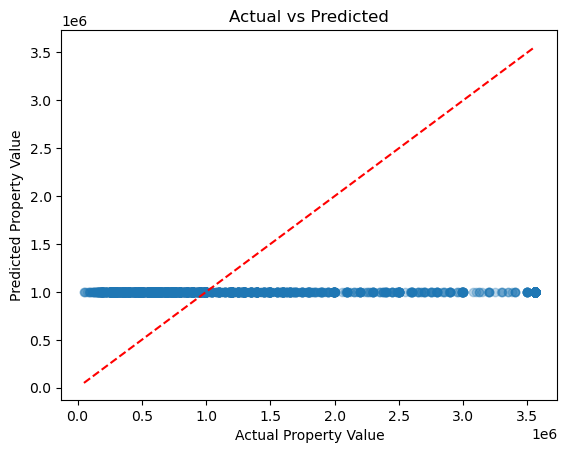

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions, alpha=0.3)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


## XGBoost

[0]	validation_0-rmse:0.78279	validation_1-rmse:0.78199
[1]	validation_0-rmse:0.72274	validation_1-rmse:0.72193
[2]	validation_0-rmse:0.67083	validation_1-rmse:0.67087
[3]	validation_0-rmse:0.62178	validation_1-rmse:0.62215
[4]	validation_0-rmse:0.57854	validation_1-rmse:0.57965
[5]	validation_0-rmse:0.54047	validation_1-rmse:0.54368
[6]	validation_0-rmse:0.50763	validation_1-rmse:0.51165
[7]	validation_0-rmse:0.47872	validation_1-rmse:0.48379
[8]	validation_0-rmse:0.45276	validation_1-rmse:0.45839
[9]	validation_0-rmse:0.43000	validation_1-rmse:0.43668
[10]	validation_0-rmse:0.41015	validation_1-rmse:0.41823
[11]	validation_0-rmse:0.39275	validation_1-rmse:0.40171
[12]	validation_0-rmse:0.37750	validation_1-rmse:0.38798
[13]	validation_0-rmse:0.36426	validation_1-rmse:0.37601
[14]	validation_0-rmse:0.35256	validation_1-rmse:0.36583
[15]	validation_0-rmse:0.34186	validation_1-rmse:0.35646
[16]	validation_0-rmse:0.33203	validation_1-rmse:0.34850
[17]	validation_0-rmse:0.32331	validation

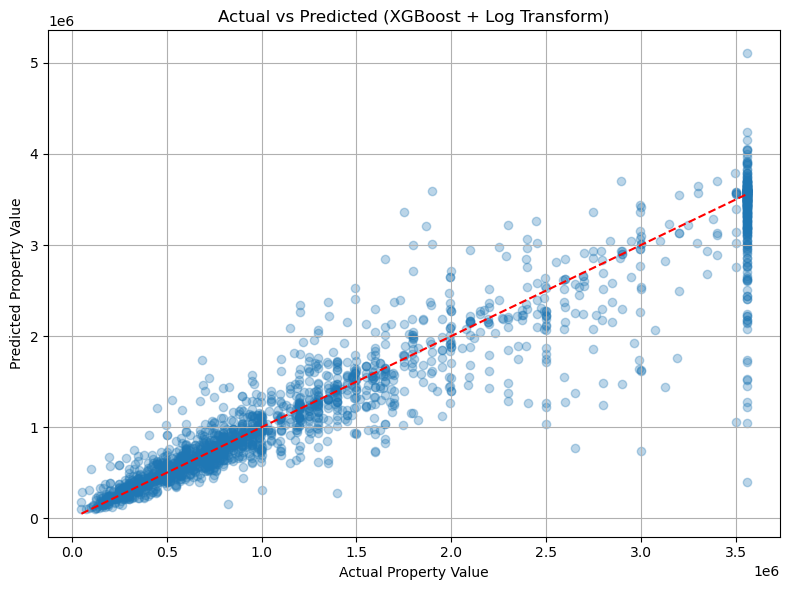

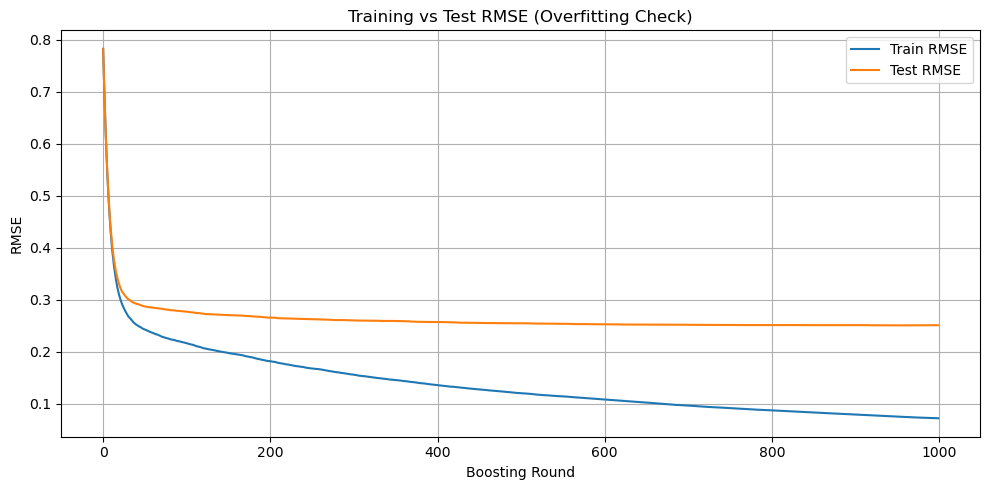

In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# ---------- Step 1: Setup ----------
target = 'Property Value'

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove(target)  # Remove target from features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

X = df[categorical_cols + numerical_cols]
y = df[target]

# ---------- Step 2: Log-transform target ----------
y_log = np.log1p(y)

# ---------- Step 3: Split ----------
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# ---------- Step 4: Preprocessing ----------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit the preprocessor and transform manually
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

import xgboost as xgb  # Make sure to import this too

# ---------- Step 5: XGBoost Model ----------
xgb_model = XGBRegressor(
    n_estimators=1000,          # Large number of estimators to allow early stopping
    learning_rate=0.1,          # Learning rate
    max_depth=6,                # Pruning: Limit tree depth
    subsample=0.8,              # Subsample ratio of the training instances
    colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
    random_state=42,            # Random seed for reproducibility
    eval_metric='rmse'
)

# ---------- Step 6: Train using callbacks ----------
xgb_model.fit(
    X_train_transformed, y_train_log,
    eval_set=[(X_train_transformed, y_train_log), (X_test_transformed, y_test_log)],  # Add evaluation sets
    verbose=True
)

# ---------- Step 7: Predict and Evaluate ----------
y_pred_log = xgb_model.predict(X_test_transformed)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_log)

mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"XGBoost with Overfitting Check:")
print(f"--------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# ---------- Step 8: Plot Actual vs Predicted ----------
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, alpha=0.3)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")
plt.title("Actual vs Predicted (XGBoost + Log Transform)")
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- Step 9: Plot RMSE over boosting rounds ----------
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), results['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(epochs), results['validation_1']['rmse'], label='Test RMSE')
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Training vs Test RMSE (Overfitting Check)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
